In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import time
import datetime
import warnings
import matplotlib.pyplot as plt

import re
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess


%matplotlib inline

warnings.filterwarnings('ignore')

# Data Description and exploration

Read Data with Pandas

In [2]:
df = pd.read_csv('/content/Equity_Apartments_Data.csv')

In [3]:
df.head(5)

Unnamed: 0  Price  Beds  Baths  sq.ft  Floor Move_in_date building_id  \
0           1   2377     0    1.0    523      5   2021-09-02          01   
1           2   2816     1    1.0    713      2   2021-09-13          01   
2           3   3811     2    2.0   1252      6   2021-10-08          01   
3           4   1549     0    1.0    456      2   2021-09-17           1   
4           5   1753     1    1.0    580      3   2021-10-05           1   

    unit_id                                                URL  ... Fireplace  \
0      0507  https://www.equityapartments.com/washington-dc...  ...       0.0   
1      0204  https://www.equityapartments.com/washington-dc...  ...       0.0   
2      0608  https://www.equityapartments.com/washington-dc...  ...       1.0   
3  256 \r\n  https://www.equityapartments.com/washington-dc...  ...       0.0   
4  337 \r\n  https://www.equityapartments.com/washington-dc...  ...       0.0   

  City_Skyline Kitchen_Island Stainless_Appliances Renovated  Office_Space  \
0          0.0            0.0                  1.0       1.0           0.0   
1          0.0            0.0                  1.0       1.0           0.0   
2          0.0            0.0                  0.0       0.0           0.0   
3          0.0            0.0                  0.0       0.0           0.0   
4          0.0            0.0                  0.0       0.0           0.0   

   Days_Till_Available  Day_of_the_week_recorded                   Unique_ID  \
0                 47.0                 Wednesday    0105071210MassApartments   
1                 58.0                 Wednesday    0102041210MassApartments   
2                 83.0                 Wednesday    0106081210MassApartments   
3                 62.0                 Wednesday  1256\r\n1500MassApartments   
4                 80.0                 Wednesday  1337\r\n1500MassApartments   

   Estiamted_Vacancy  
0           0.020833  
1           0.020833  
2           0.020833  
3           0.003597  
4           0.003597  

[5 rows x 32 columns]

In [4]:
df.columns

Index(['Unnamed: 0', 'Price', 'Beds', 'Baths', 'sq.ft', 'Floor',
       'Move_in_date', 'building_id', 'unit_id', 'URL', 'Day_Recorded',
       'Amenity', 'Apartment Name', 'Address', 'City', 'Units',
       'Northern_Exposure', 'Southern_Exposure', 'Eastern_Exposure',
       'Western_Exposure', 'Balcony', 'Walk_In_Closet', 'Fireplace',
       'City_Skyline', 'Kitchen_Island', 'Stainless_Appliances', 'Renovated',
       'Office_Space', 'Days_Till_Available', 'Day_of_the_week_recorded',
       'Unique_ID', 'Estiamted_Vacancy'],
      dtype='object')

## **The description of the data**

|           Index          |                         Description                         |
|:------------------------:|:-----------------------------------------------------------:|
|           Price          | Price (recorded daily)                                      |
|           Beds           | # of Beds in an apartment. 0 means a studio apt.            |
|           Baths          | # of baths in an apartment.                                 |
|           sq.ft          | # of square feet.                                           |
|           Floor          | Floor                                                       |
|       Move_in_date       | Date the apartment was available for move in.               |
|        building_id       | for apartments that had multiple buildings.                 |
|          unit_id         | The apartment unit number.                                  |
|            URL           | URL that was scraped.                                       |
|       Day_Recorded       | Day the row of data was scraped.                            |
|          Amenity         | Text field describing different apartment features.         |
|      Apartment Name      | Name of the apartment complex.                              |
|          Address         | Address of apartment complex.                               |
|           City           | City the apartment is in.                                   |
|           Units          | Number of units the apartment complex as a whole has.       |
|     Northern_Exposure    | 1 if apartment has northern exposure, 0 otherwise.          |
|     Southern_Exposure    | 1 if apartment has southern exposure, 0 otherwise.          |
|     Eastern_Exposure     | 1 if apartment has eastern exposure, 0 otherwise            |
|     Western_Exposure     | 1 if apartment has western exposure, 0 otherwise.           |
|          Balcony         | 1 if apartment has balcony, 0 otherwise.                    |
|      Walk_In_Closet      | 1 if apartment has walk in closet, 0 otherwise.             |
|         Fireplace        | 1 if apartment has fireplace, 0 otherwise.                  |
|       City_Skyline       | 1 if apartment has city skyline, 0 otherwise.               |
|      Kitchen_Island      | 1 if apartment has kitchen island, 0 otherwise.             |
|   Stainless_Appliances   | 1 if apartment has stainless steel appliances, 0 otherwise. |
|         Renovated        | 1 if apartment has been rennovated, 0 otherwise.            |
|       Office_Space       | 1 if apartment has office space, 0 otherwise.               |
|    Days_Till_Available   | Days until you could move in.                               |
| Day_of_the_week_recorded | What day of the week was the data scraped.                  |
|         Unique_ID        | Unique ID to identify the same apartment over many days.    |
|     Estiamted_Vacancy    | # of obvs that day/ total units for that apartment          |

## **What data features need to be cleaned. Categories of feature types**

 * 'Unnamed: 0' - need to be removed, because it is just index of the row
 * 'Price' - ensure all values are numeric, target column, need to be scaled
 * 'Beds' - ensure all values are numeric. Handle any missing values,
 * 'Baths' - ensure all values are numeric. Handle any missing values,
 * 'sq.ft' - ensure all values are numeric. Handle any missing values,
 * 'Floor' - ensure all values are numeric. Handle any missing values,
 * 'Move_in_date' - ensure all values are valid dates. Handle any missing values, convert to a standard date format,  
 * 'building_id' - text feature, ensure all values are are consistent (e.g., all text). Handle any missing values,
 * 'unit_id' - text feature, ensure all values are are consistent (e.g., all text). Handle any missing values, remove unnecessary characters,
 * 'URL' - text feature. Handle any missing values,
 * 'Day_Recorded' - datetime feature. ensure all values are valid dates. Handle any missing values, convert to a standard date format,
 * 'Amenity' - text feature, handle any missing values. Standardize text format (e.g., lowercase, remove extra spaces), remove unnecessary characters,
 * 'Apartment Name' - text feature, handle any missing values. Standardize text format (e.g., lowercase, remove extra spaces), remove unnecessary characters,
 * 'Address' - text feature, handle any missing values. Standardize text format (e.g., lowercase, remove extra spaces), remove unnecessary characters,
 * 'City' - categorical feature, handle any missing values. Standardize text format (e.g., lowercase, remove extra spaces), remove unnecessary characters,
 * 'Units' - ensure all values are numeric. Handle any missing values,
 * 'Northern_Exposure' - numeric feature, ensure all values are binary (0 or 1).
Handle any missing values,
 * 'Southern_Exposure' - numeric feature, ensure all values are binary (0 or 1).
Handle any missing values,
 * 'Eastern_Exposure' - numeric feature, ensure all values are binary (0 or 1).
Handle any missing values,
 * 'Western_Exposure' - numeric feature, ensure all values are binary (0 or 1).
Handle any missing values,
 * 'Balcony' - numeric feature, ensure all values are binary (0 or 1).
Handle any missing values,
 * 'Walk_In_Closet' - numeric feature, ensure all values are binary (0 or 1).
Handle any missing values,
 * 'Fireplace' - numeric feature, ensure all values are binary (0 or 1).
Handle any missing values,
 * 'City_Skyline' - numeric feature, ensure all values are binary (0 or 1).
Handle any missing values,
 * 'Kitchen_Island' - numeric feature, ensure all values are binary (0 or 1).
Handle any missing values,
 * 'Stainless_Appliances' - numeric feature, ensure all values are binary (0 or 1).
Handle any missing values,
 * 'Renovated' - numeric feature, ensure all values are binary (0 or 1).
Handle any missing values,
 * 'Office_Space' - numeric feature, ensure all values are binary (0 or 1).
Handle any missing values,
 * 'Days_Till_Available' - ensure all values are numeric. Handle any missing values,
 * 'Day_of_the_week_recorded' - categorical feature, handle any missing values. Standardize text format (e.g., lowercase),
 * 'Unique_ID' - text feature, ensure all values are unique for different apartments but consistent for the same apartment over multiple days. Handle any missing values,
 * 'Estiamted_Vacancy' - ensure all values are numeric and within a valid range (0-1).

**What cleaning methods you applied to get a clean data**

1. Handling Missing Values:

* Ensure columns such as 'Price', 'Beds', 'Baths', 'sq.ft', 'Floor', 'Units', 'Days_Till_Available', and 'Estimated_Vacancy' have no missing values.

2. Data Type Conversion:

* Ensure date columns are in datetime format.

3. Specific Column Cleaning

* Categorical Columns:

 * Ensure consistency in categorical entries.

* Text features Cleaning:

 * Normalize text by converting to lowercase, stripping leading/trailing whitespace and remove unnecessary characters.
 * Ensure text features are consistent and properly formatted.

4. Consistency Checks:

* Check for logical consistency between related columns, such as ensuring 'Move_in_date' is not before 'Day_Recorded'.

In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)

Remove unnecessary characters from text features

In [6]:
df[['unit_id', 'Amenity', 'Apartment Name', 'Address', 'Unique_ID']].head(10)

unit_id                                            Amenity  \
0      0507  Hard Surface Flooring Throughout\r\r\n        ...   
1      0204  Beautiful Bay Windows\r\r\n                   ...   
2      0608  Gas Fireplace\r\r\n                           ...   
3  256 \r\n  Northern Exposure\r\r\n                       ...   
4  337 \r\n  Southern Exposure\r\r\n                       ...   
5  423 \r\n                                                NaN   
6  512 \r\n                                                NaN   
7  812 \r\n  Northern Exposure\r\r\n                       ...   
8  802 \r\n                                  Southern Exposure   
9      0101  Utilities Paid by Mgmt\r\r\n                  ...   

                               Apartment Name  \
0                        1210 Mass Apartments   
1                        1210 Mass Apartments   
2                        1210 Mass Apartments   
3                        1500 Mass Apartments   
4                        1500 Mass Apartments   
5                   455 Eye Street Apartments   
6                   455 Eye Street Apartments   
7                     \r\n425 Mass Apartments   
8                     \r\n425 Mass Apartments   
9  Corcoran House at Dupont Circle Apartments   

                                             Address  \
0  1210 Massachusetts Ave, NW\r\n\r\nWashington D...   
1  1210 Massachusetts Ave, NW\r\n\r\nWashington D...   
2  1210 Massachusetts Ave, NW\r\n\r\nWashington D...   
3  1500 Massachusetts Avenue NW\r\n\r\nWashington...   
4  1500 Massachusetts Avenue NW\r\n\r\nWashington...   
5             455 I St NW\r\n\r\nWashington DC 20001   
6             455 I St NW\r\n\r\nWashington DC 20001   
7  425 Massachusetts Avenue NW\r\n\r\nWashington ...   
8  425 Massachusetts Avenue NW\r\n\r\nWashington ...   
9        1616 18th St. NW\r\n\r\nWashington DC 20009   

                                     Unique_ID  
0                     0105071210MassApartments  
1                     0102041210MassApartments  
2                     0106081210MassApartments  
3                   1256\r\n1500MassApartments  
4                   1337\r\n1500MassApartments  
5               1423\r\n455EyeStreetApartments  
6               1512\r\n455EyeStreetApartments  
7              401812\r\n\r\n425MassApartments  
8              401802\r\n\r\n425MassApartments  
9  010101CorcoranHouseatDupontCircleApartments

In [7]:
df['unit_id'] = df['unit_id'].str.strip()
df['Apartment Name'] = df['Apartment Name'].str.strip().str.lower()

In [8]:
df.Address.head()

0    1210 Massachusetts Ave, NW\r\n\r\nWashington D...
1    1210 Massachusetts Ave, NW\r\n\r\nWashington D...
2    1210 Massachusetts Ave, NW\r\n\r\nWashington D...
3    1500 Massachusetts Avenue NW\r\n\r\nWashington...
4    1500 Massachusetts Avenue NW\r\n\r\nWashington...
Name: Address, dtype: object

In [9]:
def clean_address(address):
    cleaned_address = address.replace('\r\n', ' ').replace('\n', ' ').replace('\r', ' ')
    cleaned_address = ' '.join(cleaned_address.split())
    return cleaned_address

df['Address'] = df['Address'].apply(clean_address).str.lower()


In [10]:
def clean_description(description):
    if isinstance(description, str):
        cleaned_string = re.sub(r'[\r\n]+', ' ', description).strip()
        return cleaned_string
    else:
        return description


df['Amenity'] = df['Amenity'].apply(clean_description).str.lower()

#clean excess spaces
def remove_numbers(text):
    if isinstance(text, str):
        return re.sub(r'\s+', ' ', text).strip()
    return text


df['Amenity'] = df['Amenity'].astype(str)
df['Amenity'] = df['Amenity'].apply(remove_numbers)

In [11]:
df.Unique_ID.head(15)

0                        0105071210MassApartments
1                        0102041210MassApartments
2                        0106081210MassApartments
3                      1256\r\n1500MassApartments
4                      1337\r\n1500MassApartments
5                  1423\r\n455EyeStreetApartments
6                  1512\r\n455EyeStreetApartments
7                 401812\r\n\r\n425MassApartments
8                 401802\r\n\r\n425MassApartments
9     010101CorcoranHouseatDupontCircleApartments
10    010306CorcoranHouseatDupontCircleApartments
11         010426TheFlatsatDupontCircleApartments
12         010831TheFlatsatDupontCircleApartments
13         010702TheFlatsatDupontCircleApartments
14                  001126\r\n\r\n2400MApartments
Name: Unique_ID, dtype: object

In [12]:
def clean_string(text):
  if isinstance(text, str):
    cleaned_text = re.sub(r'[\r\n]+', '', text)
    cleaned_text = re.sub(r'\s+', '', cleaned_text.strip())
    return cleaned_text
  else:
        return text


df['Unique_ID'] = df['Unique_ID'].apply(clean_string).str.lower()

In [13]:
df[['unit_id', 'Amenity', 'Apartment Name','Address', 'Unique_ID']].head(10)

unit_id                                            Amenity  \
0    0507  hard surface flooring throughout northern expo...   
1    0204  beautiful bay windows hard surface flooring th...   
2    0608  gas fireplace hard surface flooring throughout...   
3     256  northern exposure utilities paid by mgmt walk-...   
4     337  southern exposure upgraded kitchen features ut...   
5     423                                                nan   
6     512                                                nan   
7     812                 northern exposure western exposure   
8     802                                  southern exposure   
9    0101            utilities paid by mgmt western exposure   

                               Apartment Name  \
0                        1210 mass apartments   
1                        1210 mass apartments   
2                        1210 mass apartments   
3                        1500 mass apartments   
4                        1500 mass apartments   
5                   455 eye street apartments   
6                   455 eye street apartments   
7                         425 mass apartments   
8                         425 mass apartments   
9  corcoran house at dupont circle apartments   

                                            Address  \
0    1210 massachusetts ave, nw washington dc 20005   
1    1210 massachusetts ave, nw washington dc 20005   
2    1210 massachusetts ave, nw washington dc 20005   
3  1500 massachusetts avenue nw washington dc 20005   
4  1500 massachusetts avenue nw washington dc 20005   
5                   455 i st nw washington dc 20001   
6                   455 i st nw washington dc 20001   
7   425 massachusetts avenue nw washington dc 20001   
8   425 massachusetts avenue nw washington dc 20001   
9              1616 18th st. nw washington dc 20009   

                                     Unique_ID  
0                     0105071210massapartments  
1                     0102041210massapartments  
2                     0106081210massapartments  
3                       12561500massapartments  
4                       13371500massapartments  
5                   1423455eyestreetapartments  
6                   1512455eyestreetapartments  
7                      401812425massapartments  
8                      401802425massapartments  
9  010101corcoranhouseatdupontcircleapartments

## **The quantity of the data**

In [14]:
df.shape

(62810, 31)

62 810 rows and 31 columns.

## **Categories of feature types**

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62810 entries, 0 to 62809
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     62810 non-null  int64  
 1   Beds                      62810 non-null  int64  
 2   Baths                     62810 non-null  float64
 3   sq.ft                     62810 non-null  int64  
 4   Floor                     62810 non-null  int64  
 5   Move_in_date              62022 non-null  object 
 6   building_id               61958 non-null  object 
 7   unit_id                   61958 non-null  object 
 8   URL                       62810 non-null  object 
 9   Day_Recorded              62810 non-null  object 
 10  Amenity                   62810 non-null  object 
 11  Apartment Name            62810 non-null  object 
 12  Address                   62810 non-null  object 
 13  City                      62810 non-null  object 
 14  Units 

In [16]:
types = df.dtypes
print("Number categorical features:", sum(types=='object'))
print(types)

Number categorical features: 11
Price                         int64
Beds                          int64
Baths                       float64
sq.ft                         int64
Floor                         int64
Move_in_date                 object
building_id                  object
unit_id                      object
URL                          object
Day_Recorded                 object
Amenity                      object
Apartment Name               object
Address                      object
City                         object
Units                         int64
Northern_Exposure           float64
Southern_Exposure           float64
Eastern_Exposure            float64
Western_Exposure            float64
Balcony                     float64
Walk_In_Closet              float64
Fireplace                   float64
City_Skyline                float64
Kitchen_Island              float64
Stainless_Appliances        float64
Renovated                   float64
Office_Space                floa

In [17]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

Remove all columns from categorical_columns except 'categorical' or text to see their unique values

In [18]:
categorical_columns = categorical_columns.drop(['Move_in_date', 'Day_Recorded'])

In [19]:
numeric_features = df.select_dtypes(include=['float', 'int']).columns

In [20]:
df.describe()

Price          Beds         Baths         sq.ft         Floor  \
count  62810.000000  62810.000000  62810.000000  62810.000000  62810.000000   
mean    3003.879287      1.291291      1.356934    846.905827      6.417736   
std     1023.920288      0.707895      0.483811    250.359228      7.287391   
min        0.000000      0.000000      1.000000    210.000000      1.000000   
25%     2289.000000      1.000000      1.000000    674.000000      2.000000   
50%     2803.500000      1.000000      1.000000    782.000000      3.000000   
75%     3453.750000      2.000000      2.000000   1046.000000      8.000000   
max    12091.000000      3.000000      3.000000   1917.000000    100.000000   

              Units  Northern_Exposure  Southern_Exposure  Eastern_Exposure  \
count  62810.000000       60319.000000       60319.000000      60319.000000   
mean     338.785528           0.207464           0.188697          0.231453   
std      147.851929           0.405494           0.391271          0.421765   
min       18.000000           0.000000           0.000000          0.000000   
25%      229.000000           0.000000           0.000000          0.000000   
50%      316.000000           0.000000           0.000000          0.000000   
75%      444.000000           0.000000           0.000000          0.000000   
max      761.000000           1.000000           1.000000          1.000000   

       Western_Exposure       Balcony  Walk_In_Closet     Fireplace  \
count      60319.000000  60319.000000    60319.000000  60319.000000   
mean           0.223644      0.240903        0.119316      0.089358   
std            0.416690      0.427635        0.324162      0.285263   
min            0.000000      0.000000        0.000000      0.000000   
25%            0.000000      0.000000        0.000000      0.000000   
50%            0.000000      0.000000        0.000000      0.000000   
75%            0.000000      0.000000        0.000000      0.000000   
max            1.000000      1.000000        1.000000      1.000000   

       City_Skyline  Kitchen_Island  Stainless_Appliances     Renovated  \
count  60319.000000    60319.000000          60319.000000  60319.000000   
mean       0.027786        0.038363              0.079411      0.210050   
std        0.164359        0.192072              0.270382      0.407347   
min        0.000000        0.000000              0.000000      0.000000   
25%        0.000000        0.000000              0.000000      0.000000   
50%        0.000000        0.000000              0.000000      0.000000   
75%        0.000000        0.000000              0.000000      0.000000   
max        1.000000        1.000000              1.000000      1.000000   

       Office_Space  Days_Till_Available  Estiamted_Vacancy  
count  60319.000000         62022.000000       62810.000000  
mean       0.021303            27.174857           0.081126  
std        0.144395            25.531519           0.103878  
min        0.000000             0.000000           0.001773  
25%        0.000000             3.000000           0.041667  
50%        0.000000            23.000000           0.059925  
75%        0.000000            44.000000           0.077348  
max        1.000000           434.000000           0.675325

## **How many unique values per feature**

In [21]:
for column in df.columns:
    print(f'Count of Unique values of {column}: {df[column].nunique()}', '\n\n')

Count of Unique values of Price: 4556 


Count of Unique values of Beds: 4 


Count of Unique values of Baths: 5 


Count of Unique values of sq.ft: 901 


Count of Unique values of Floor: 48 


Count of Unique values of Move_in_date: 128 


Count of Unique values of building_id: 336 


Count of Unique values of unit_id: 2292 


Count of Unique values of URL: 265 


Count of Unique values of Day_Recorded: 32 


Count of Unique values of Amenity: 3080 


Count of Unique values of Apartment Name: 264 


Count of Unique values of Address: 265 


Count of Unique values of City: 10 


Count of Unique values of Units: 199 


Count of Unique values of Northern_Exposure: 2 


Count of Unique values of Southern_Exposure: 2 


Count of Unique values of Eastern_Exposure: 2 


Count of Unique values of Western_Exposure: 2 


Count of Unique values of Balcony: 2 


Count of Unique values of Walk_In_Closet: 2 


Count of Unique values of Fireplace: 2 


Count of Unique values of City_Skyline: 2 


C

In [22]:
for column in df.columns:
    print(f'Unique values of {column}: {df[column].unique()}', '\n')

Unique values of Price: [2377 2816 3811 ... 4054 5362 1637] 

Unique values of Beds: [0 1 2 3] 

Unique values of Baths: [1.  2.  1.5 3.  2.5] 

Unique values of sq.ft: [ 523  713 1252  456  580  556  656  468  679  420  750  475  715 1090
  577  730 1400  419  759  938  500  800 1180  450 1750  875  625  719
  818  665  955  725  683 1055  633 1053  714  945  593  630  950 1075
  564 1080 1100  760 1227 1039  362  867  806  960 1261  565  637  685
 1057 1456 1235  701  631 1020  834 1011  469  792 1019  644  877  660
 1097  614  827  541  499  963  674 1059 1447  707 1052 1257  744 1048
  776 1168  491  747 1114 1449  815 1203  728  838  673 1072 1320  664
 1031  480  823  555 1110  439  636  635  888  486  692  650  481  694
  904  567  682  592 1352  408  501  724  448  697 1043  466  654  277
  364  632  465  600  655  461  933 1395  435  860  521  534  548  504
 1116  640  832  545  913  843  533  866  553  668  616  690  903  605
  645 1171  618  641  612  972  751  965  512  740

In [23]:
df[categorical_columns]

building_id unit_id                                                URL  \
0              01    0507  https://www.equityapartments.com/washington-dc...   
1              01    0204  https://www.equityapartments.com/washington-dc...   
2              01    0608  https://www.equityapartments.com/washington-dc...   
3               1     256  https://www.equityapartments.com/washington-dc...   
4               1     337  https://www.equityapartments.com/washington-dc...   
...           ...     ...                                                ...   
62805         NaN     NaN  https://www.equityapartments.com/arlington/cou...   
62806         NaN     NaN  https://www.equityapartments.com/arlington/cou...   
62807         NaN     NaN  https://www.equityapartments.com/arlington/cou...   
62808         NaN     NaN  https://www.equityapartments.com/arlington/cou...   
62809         NaN     NaN  https://www.equityapartments.com/arlington/cou...   

                                                 Amenity  \
0      hard surface flooring throughout northern expo...   
1      beautiful bay windows hard surface flooring th...   
2      gas fireplace hard surface flooring throughout...   
3      northern exposure utilities paid by mgmt walk-...   
4      southern exposure upgraded kitchen features ut...   
...                                                  ...   
62805                                   northern western   
62806                                   northern western   
62807                                   southern western   
62808                                        northern na   
62809                                   eastern southern   

                    Apartment Name  \
0             1210 mass apartments   
1             1210 mass apartments   
2             1210 mass apartments   
3             1500 mass apartments   
4             1500 mass apartments   
...                            ...   
62805  courthouse plaza apartments   
62806  courthouse plaza apartments   
62807  courthouse plaza apartments   
62808  courthouse plaza apartments   
62809  courthouse plaza apartments   

                                                Address           City  \
0        1210 massachusetts ave, nw washington dc 20005  Washington DC   
1        1210 massachusetts ave, nw washington dc 20005  Washington DC   
2        1210 massachusetts ave, nw washington dc 20005  Washington DC   
3      1500 massachusetts avenue nw washington dc 20005  Washington DC   
4      1500 massachusetts avenue nw washington dc 20005  Washington DC   
...                                                 ...            ...   
62805           2250 clarendon blvd. arlington va 22201  Washington DC   
62806           2250 clarendon blvd. arlington va 22201  Washington DC   
62807           2250 clarendon blvd. arlington va 22201  Washington DC   
62808           2250 clarendon blvd. arlington va 22201  Washington DC   
62809           2250 clarendon blvd. arlington va 22201  Washington DC   

      Day_of_the_week_recorded                 Unique_ID  
0                    Wednesday  0105071210massapartments  
1                    Wednesday  0102041210massapartments  
2                    Wednesday  0106081210massapartments  
3                    Wednesday    12561500massapartments  
4                    Wednesday    13371500massapartments  
...                        ...                       ...  
62805                   Sunday                       NaN  
62806                   Sunday                       NaN  
62807                   Sunday                       NaN  
62808                   Sunday                       NaN  
62809                   Sunday                       NaN  

[62810 rows x 9 columns]

## **Bivariate Analysis**

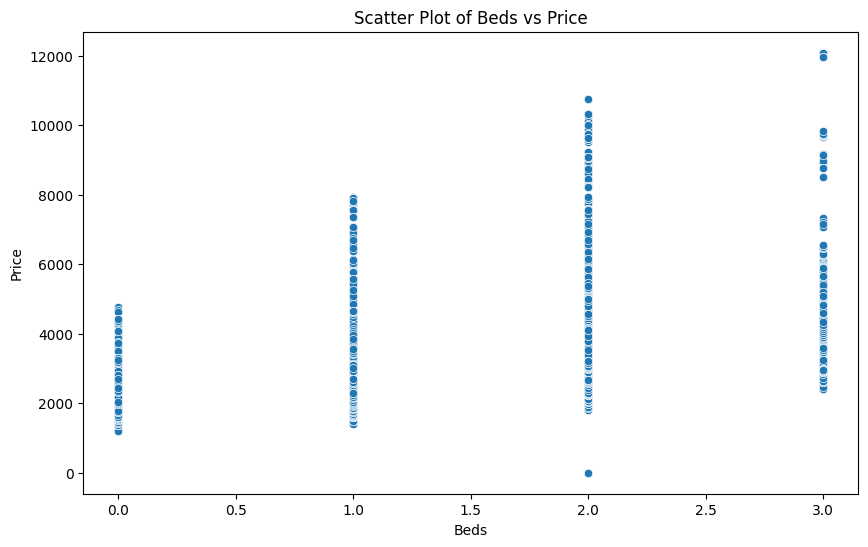

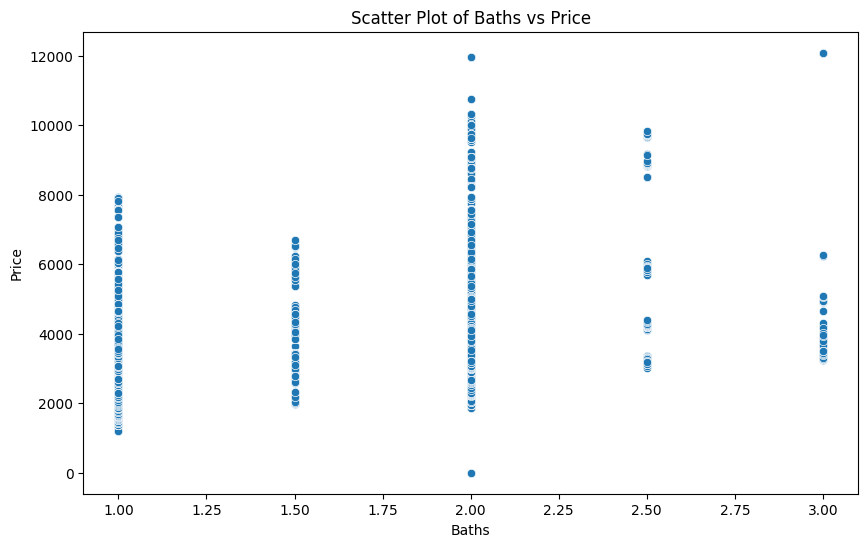

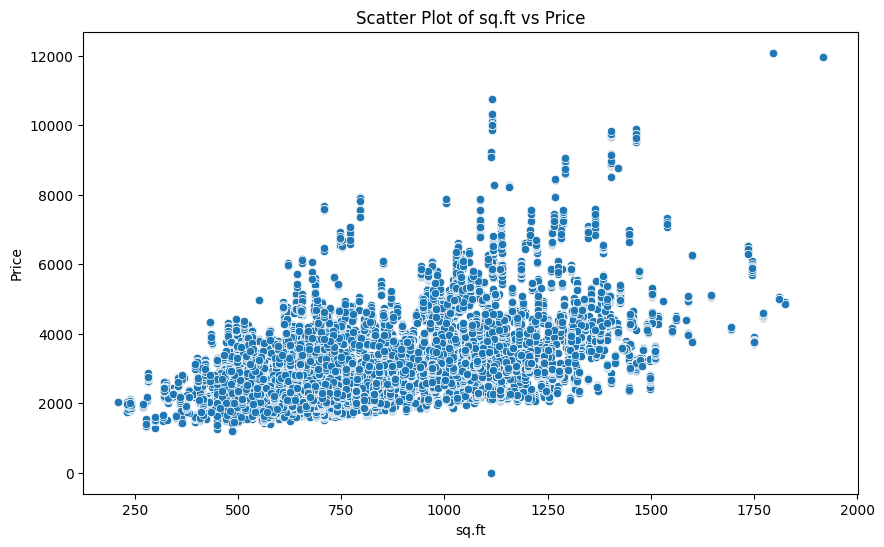

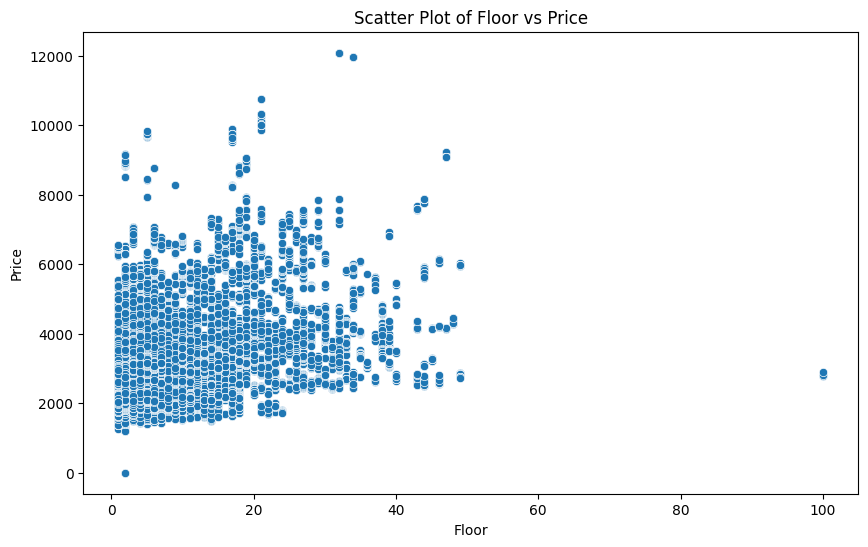

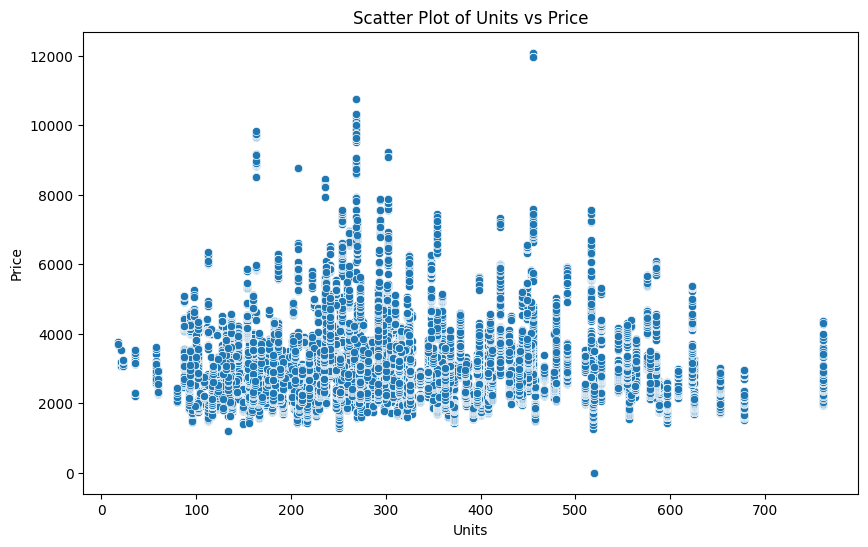

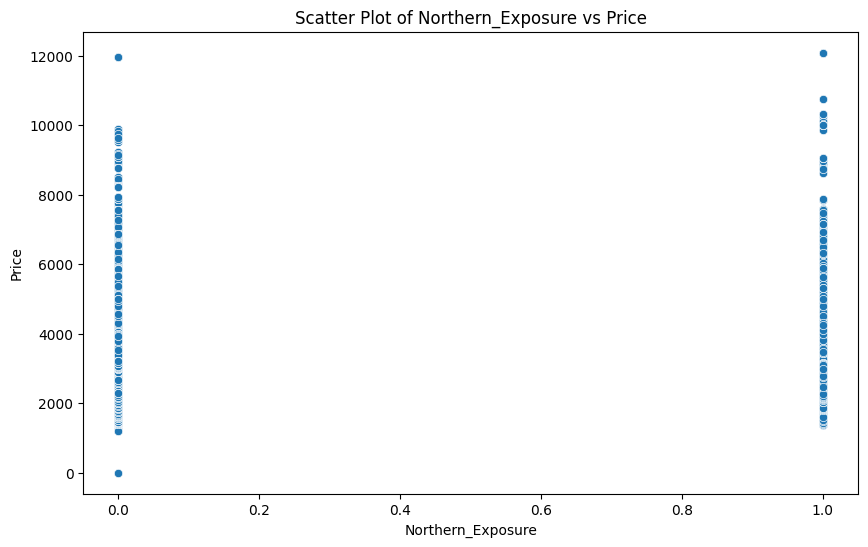

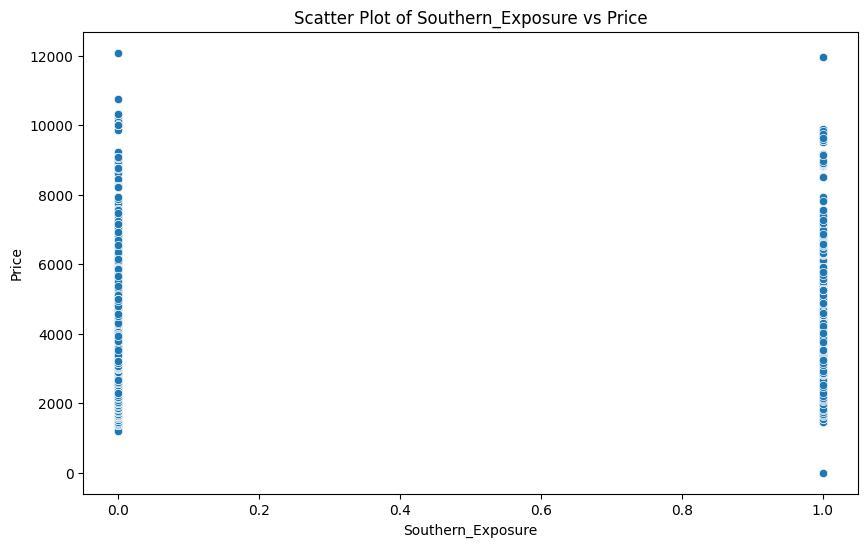

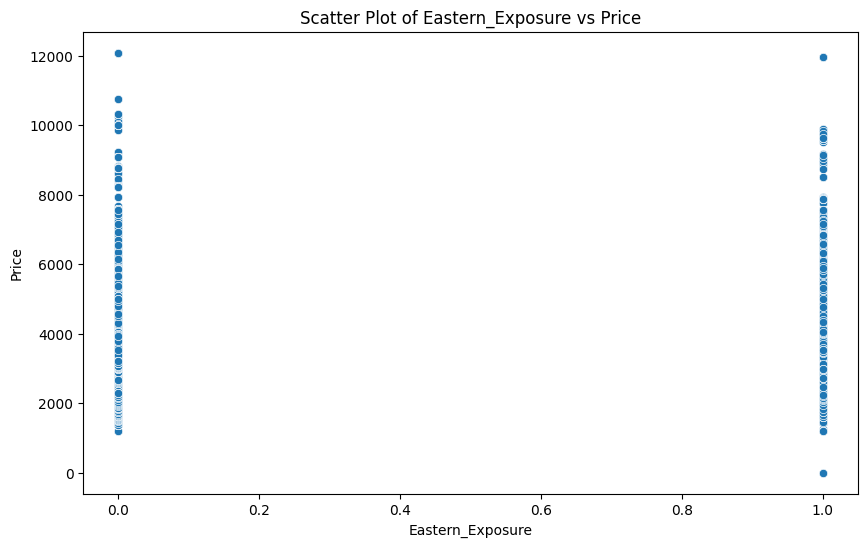

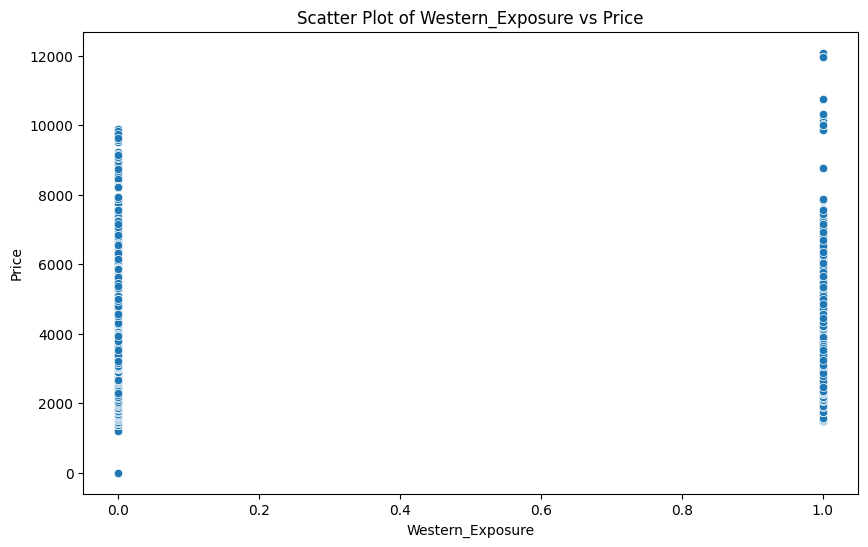

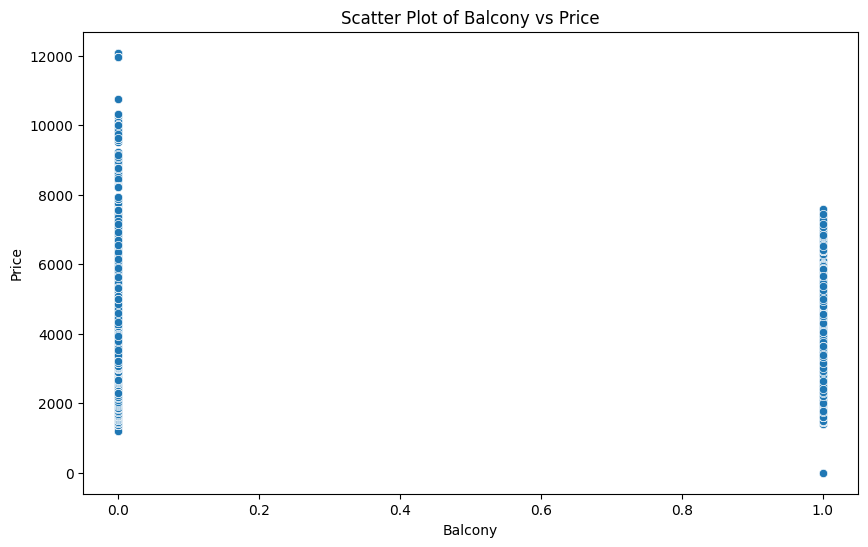

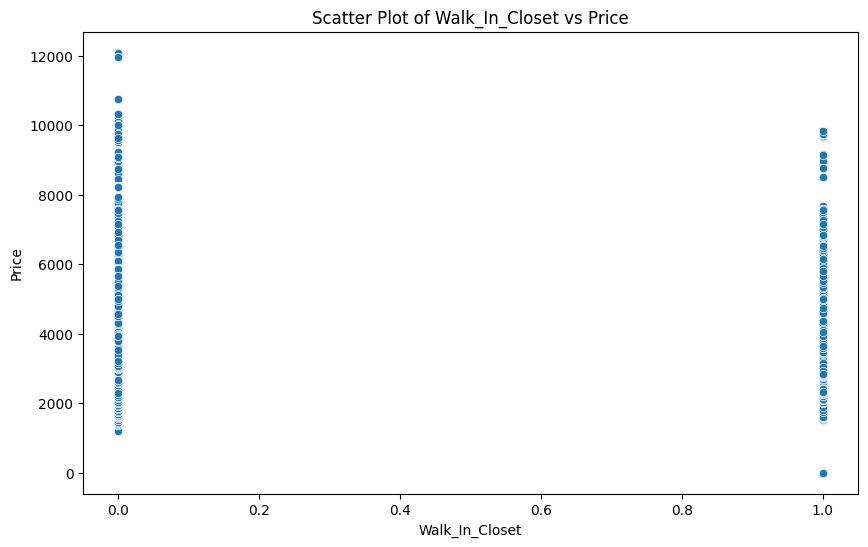

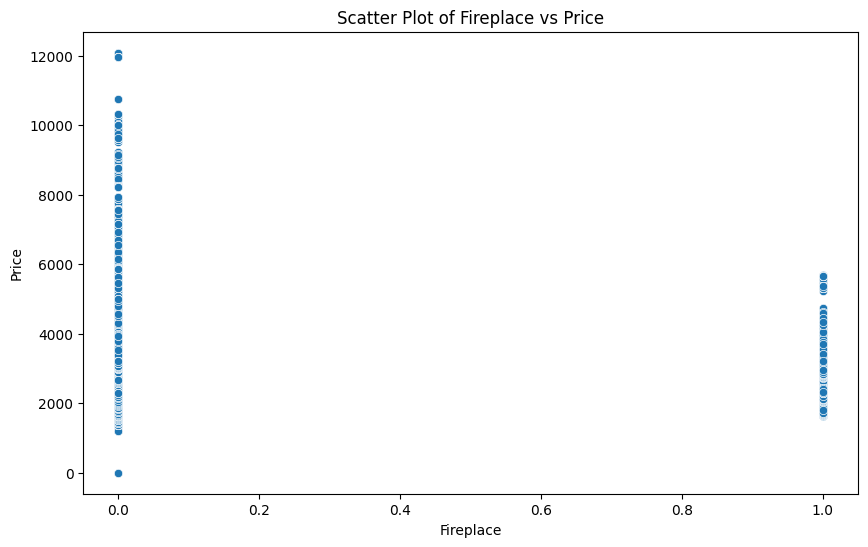

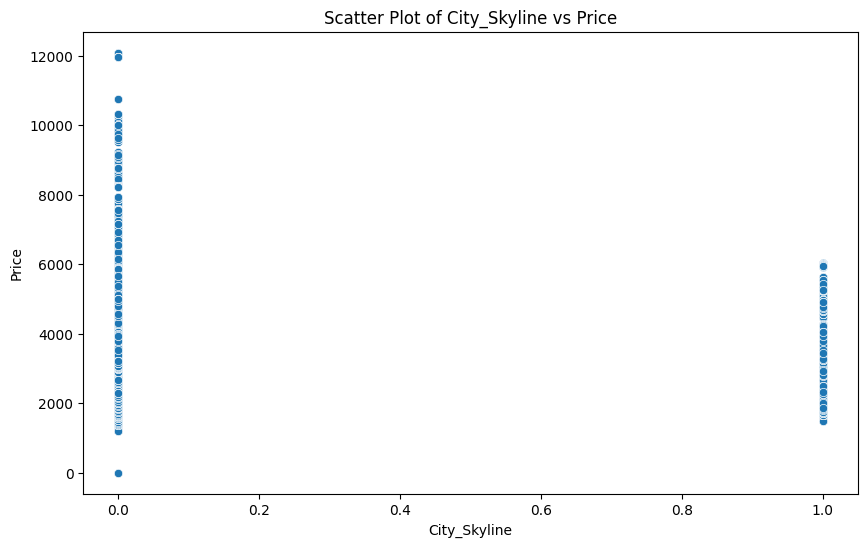

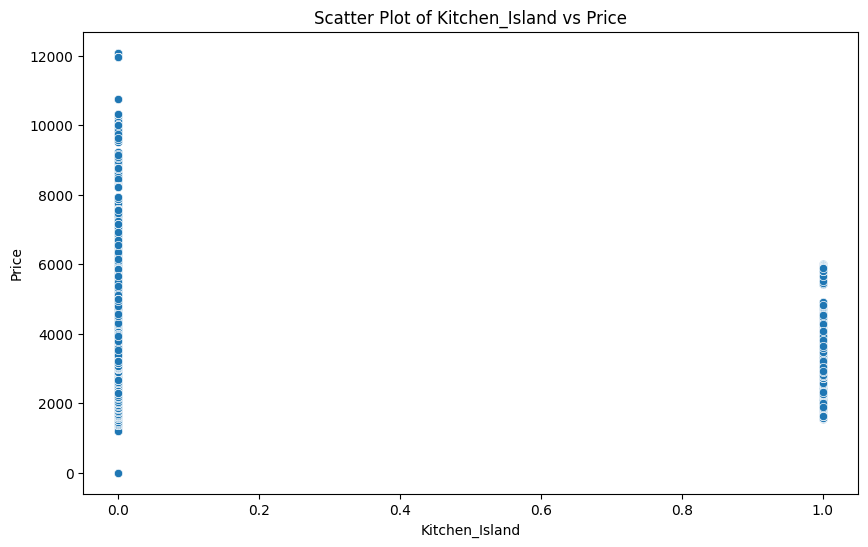

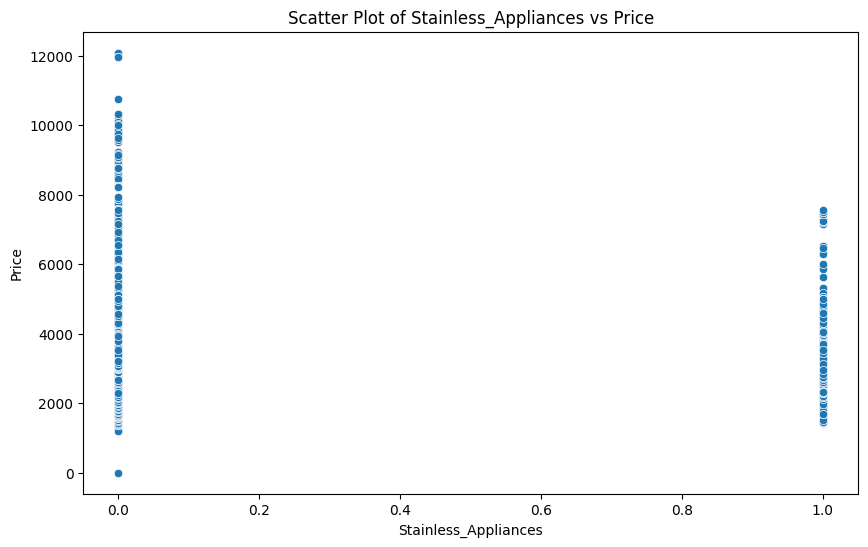

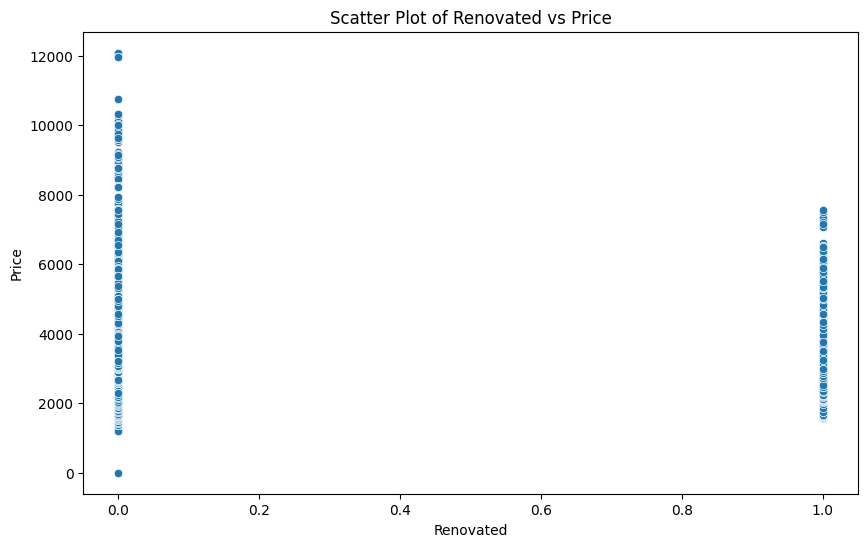

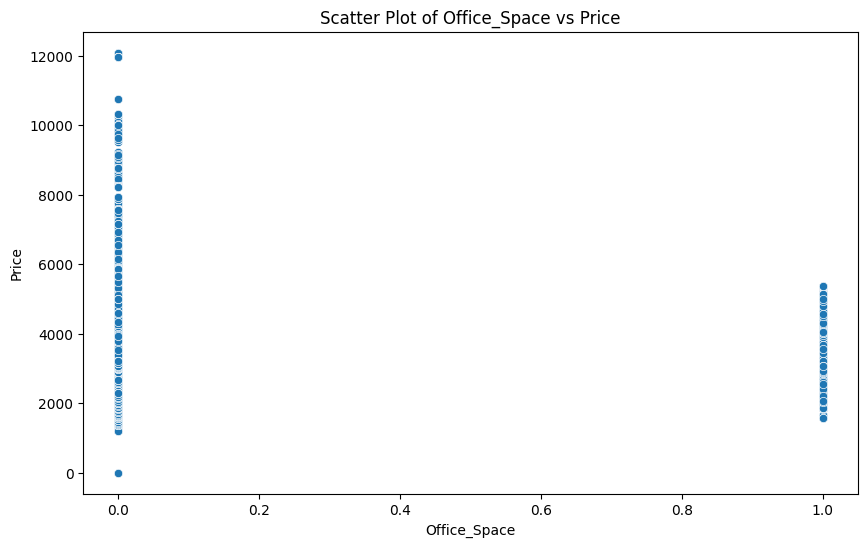

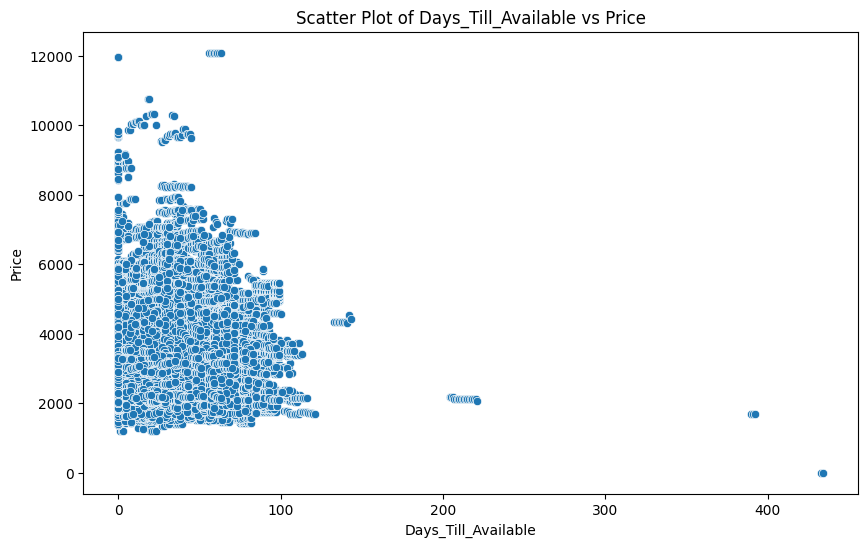

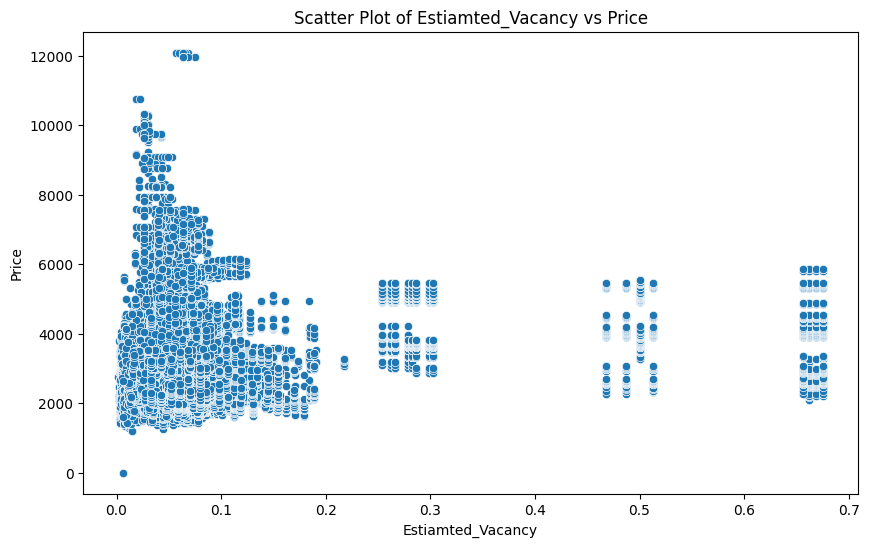

In [24]:
# Scatter plots for numerical features vs. Price
numerical_features = numeric_features.drop('Price')
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=feature, y='Price')
    plt.title(f'Scatter Plot of {feature} vs Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

Based on the graphs obtained, it can be seen that linear relationships between there are potential linear relationship between price and sq.fit, Floor.

In [25]:
# Calculate the correlation matrix
corr_matrix = df[list(numerical_features) + ['Price']].corr()

# Display the correlation coefficients with Price
print(corr_matrix['Price'].sort_values(ascending=False))


Price                   1.000000
sq.ft                   0.505921
Baths                   0.455451
Beds                    0.453953
Floor                   0.375788
Walk_In_Closet          0.175117
Estiamted_Vacancy       0.149306
Northern_Exposure       0.076524
Office_Space            0.066430
Eastern_Exposure        0.050940
Western_Exposure        0.037104
Days_Till_Available     0.035980
Southern_Exposure       0.034644
Stainless_Appliances    0.010724
Kitchen_Island          0.007746
Balcony                -0.008306
City_Skyline           -0.016931
Fireplace              -0.065119
Renovated              -0.067820
Units                  -0.113648
Name: Price, dtype: float64


The Pearson Correlation Coefficient measures the linear relationship between two datasets. The values always range between -1 (perfect negative correlation) and +1 (perfect positive correlation). A value of 0 implies no correlation. Here's a brief analysis of your data:

- **Price and sq.ft (0.505921)**: There is a moderate positive correlation. As the square footage of a property increases, the price tends to increase as well.
- **Price and Baths (0.455451)**, **Price and Beds (0.453953)**: There is a moderate positive correlation. More baths or beds in a property are associated with a higher price.
- **Price and Floor (0.375788)**: There is a weak positive correlation. Higher floors might be associated with a higher price, but the relationship is not very strong.
- **Price and Walk_In_Closet (0.175117)**, **Price and Estimated_Vacancy (0.149306)**: These features have a very weak positive correlation with the price.
- **Price and Northern_Exposure (0.076524)**, **Price and Office_Space (0.066430)**, and others till **Price and Stainless_Appliances (0.010724)**: These features have a negligible positive correlation with the price.
- **Price and Balcony (-0.008306)**, **Price and City_Skyline (-0.016931)**, and others till **Price and Units (-0.113648)**: These features have a negligible to weak negative correlation with the price.


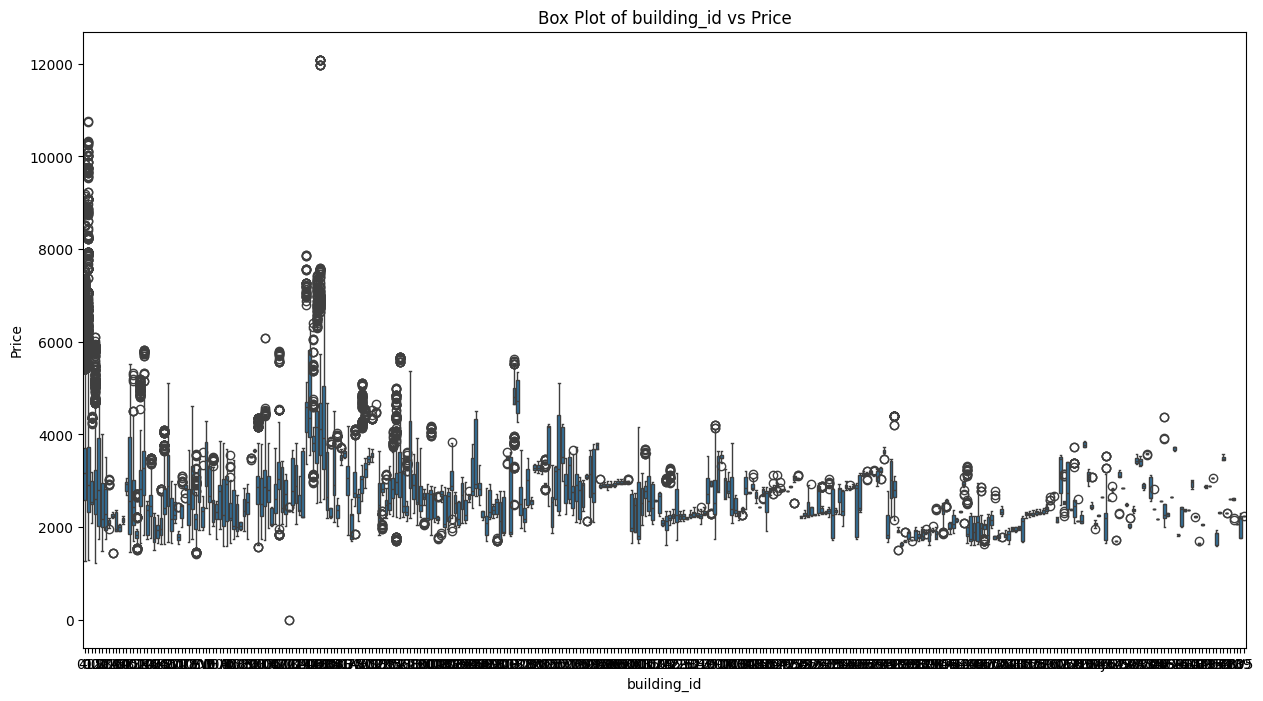

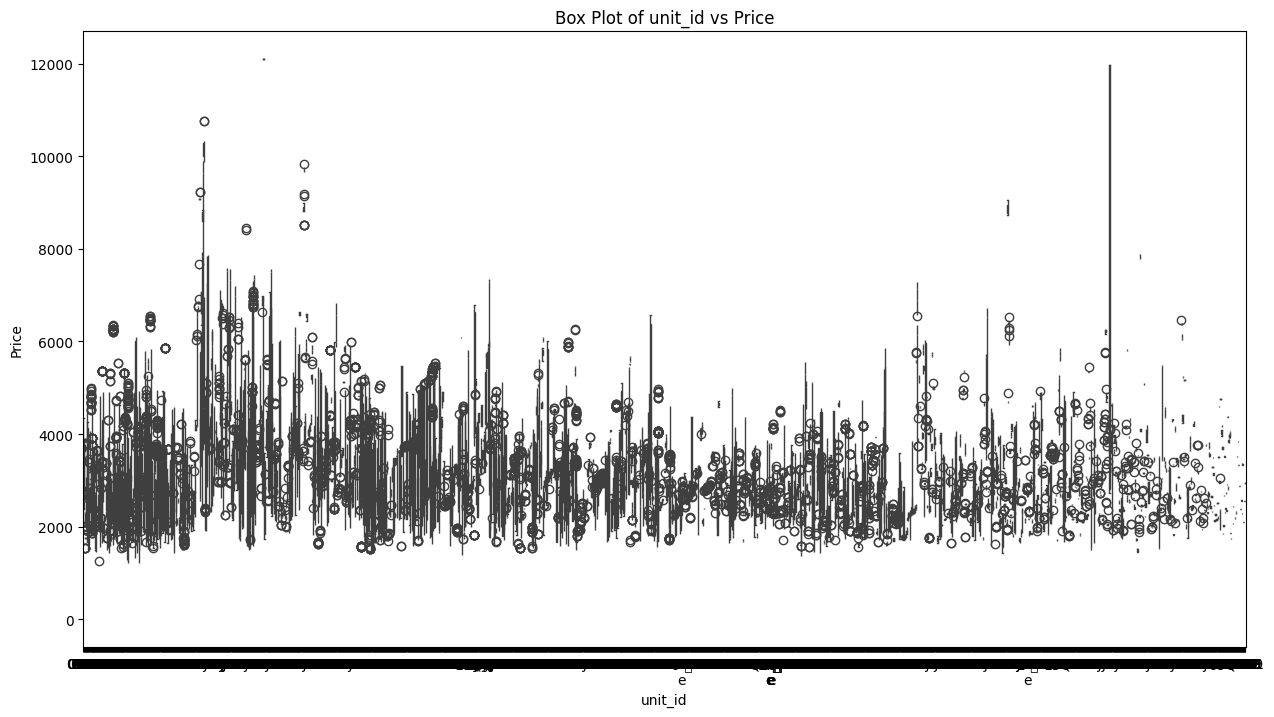

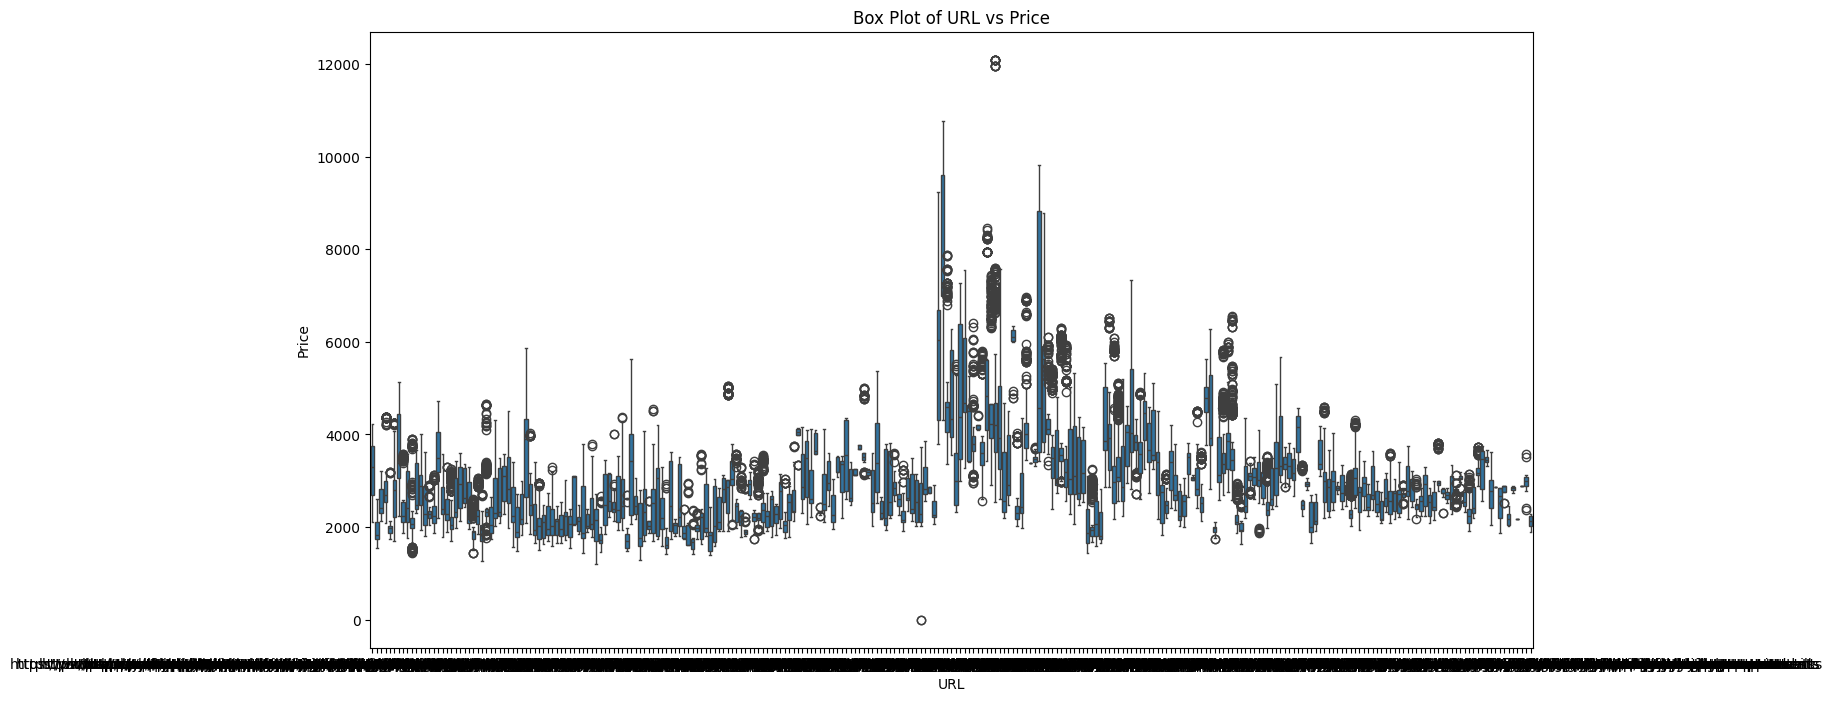

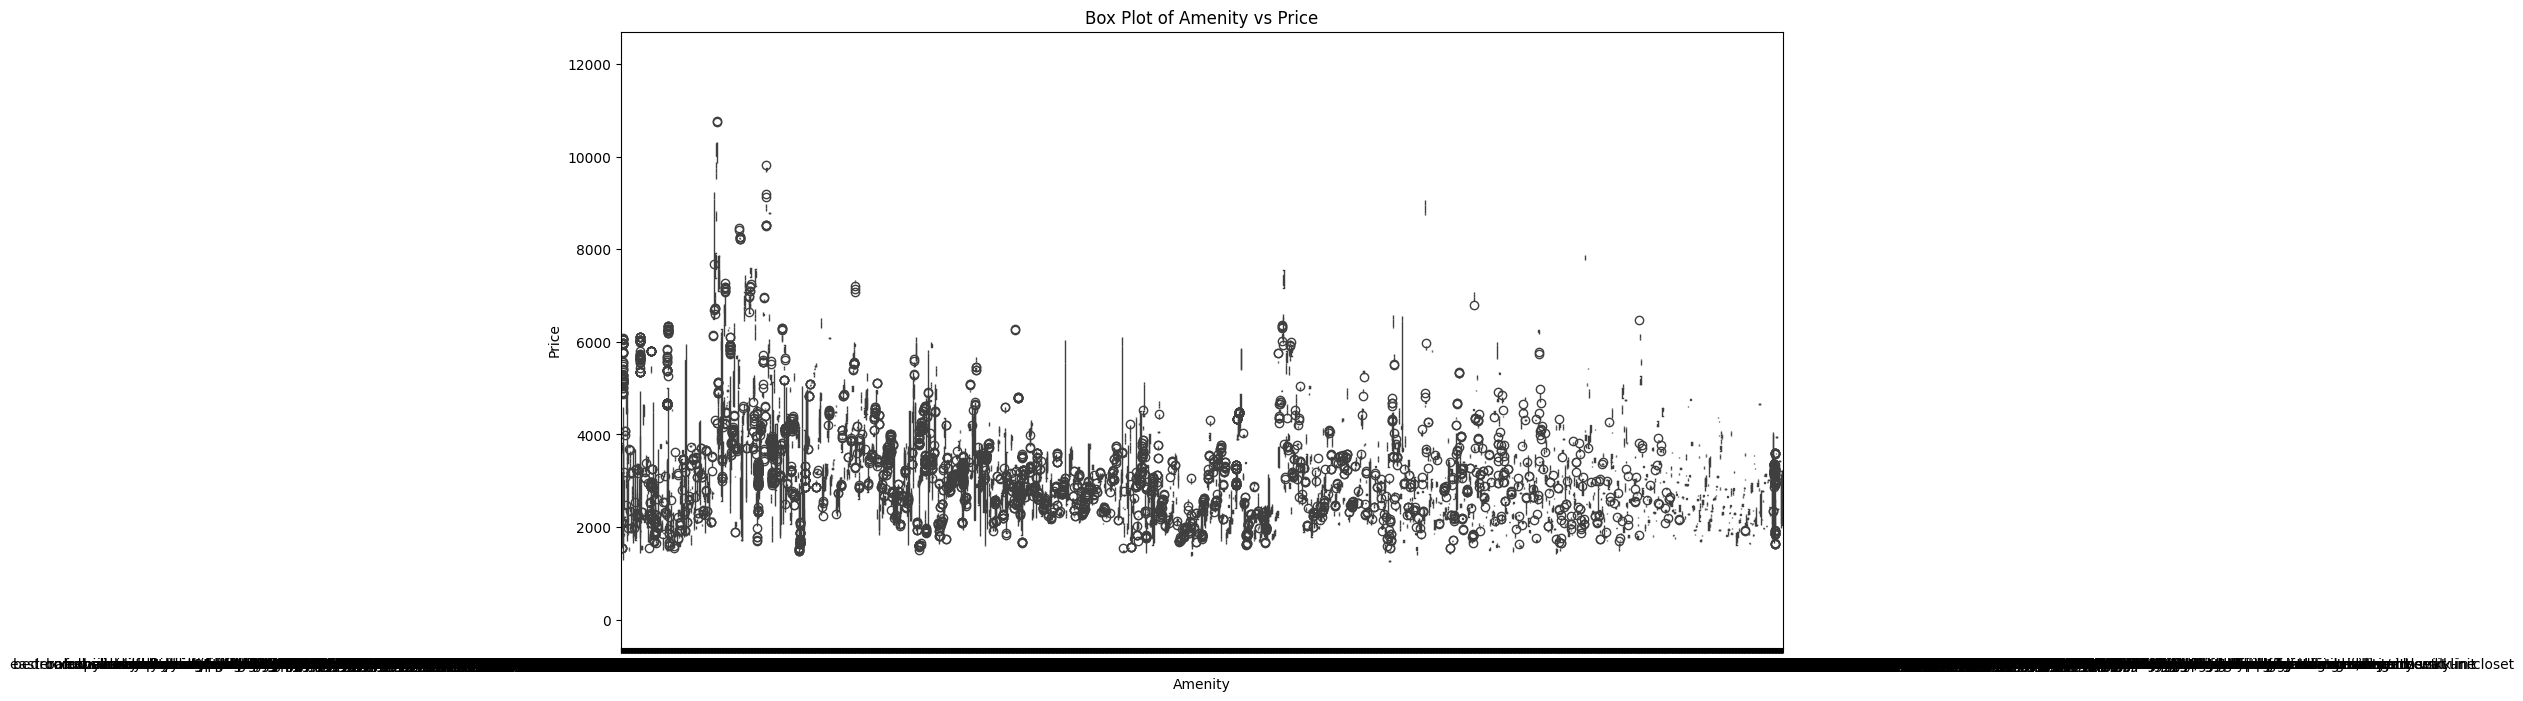

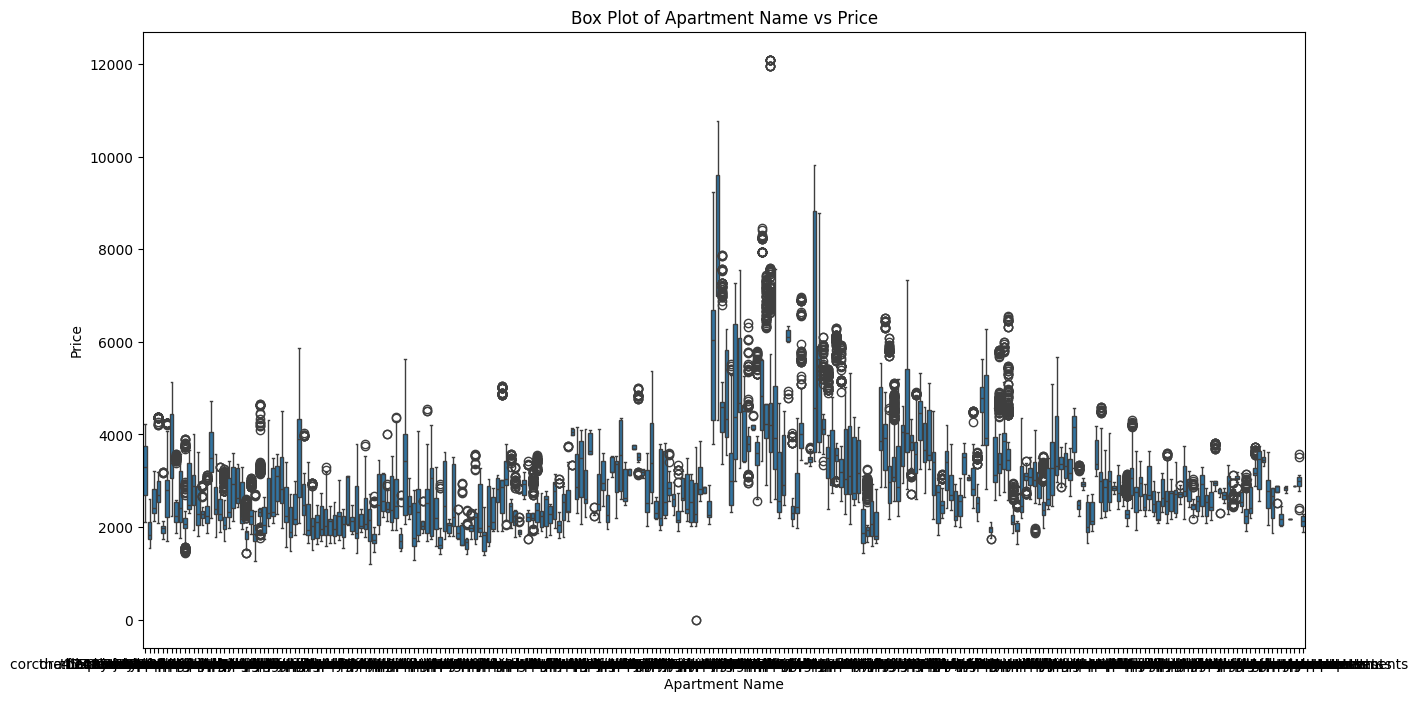

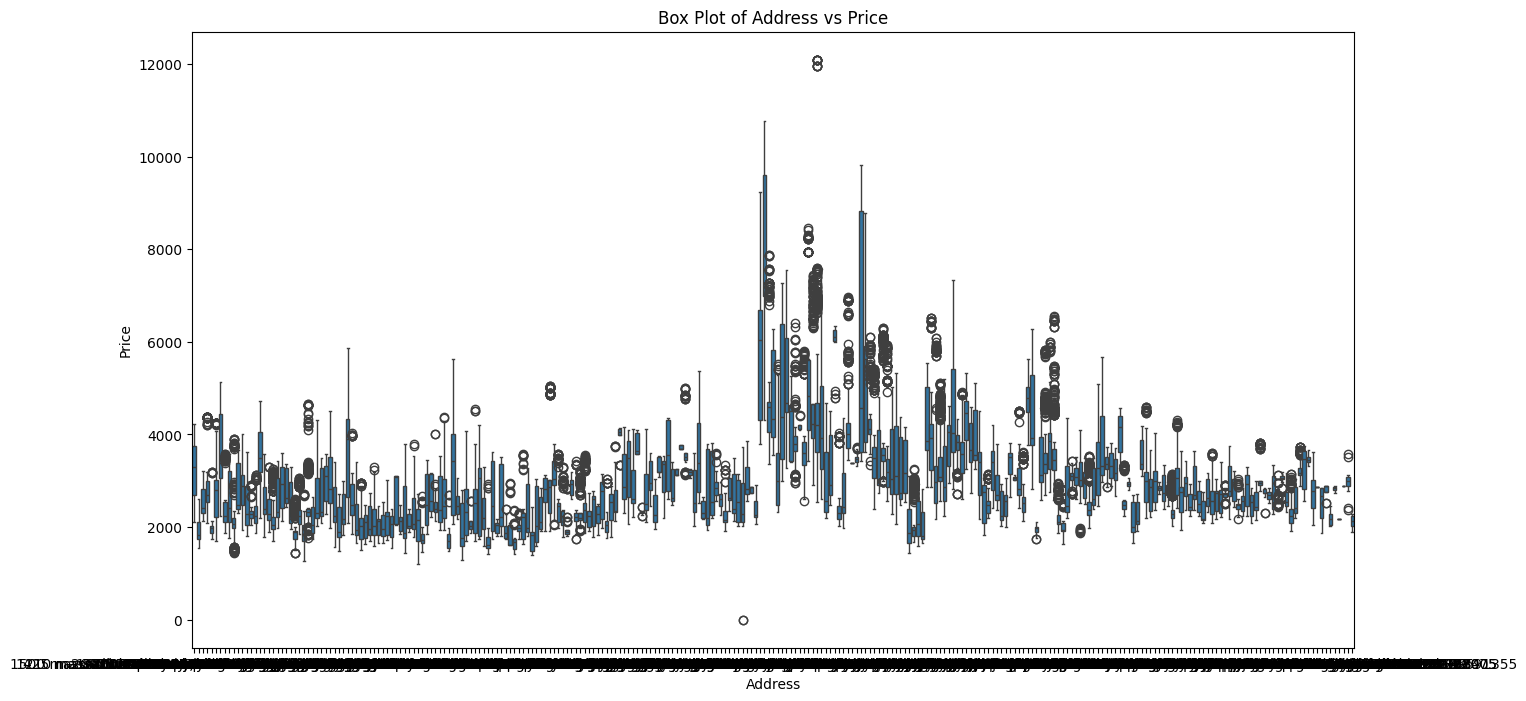

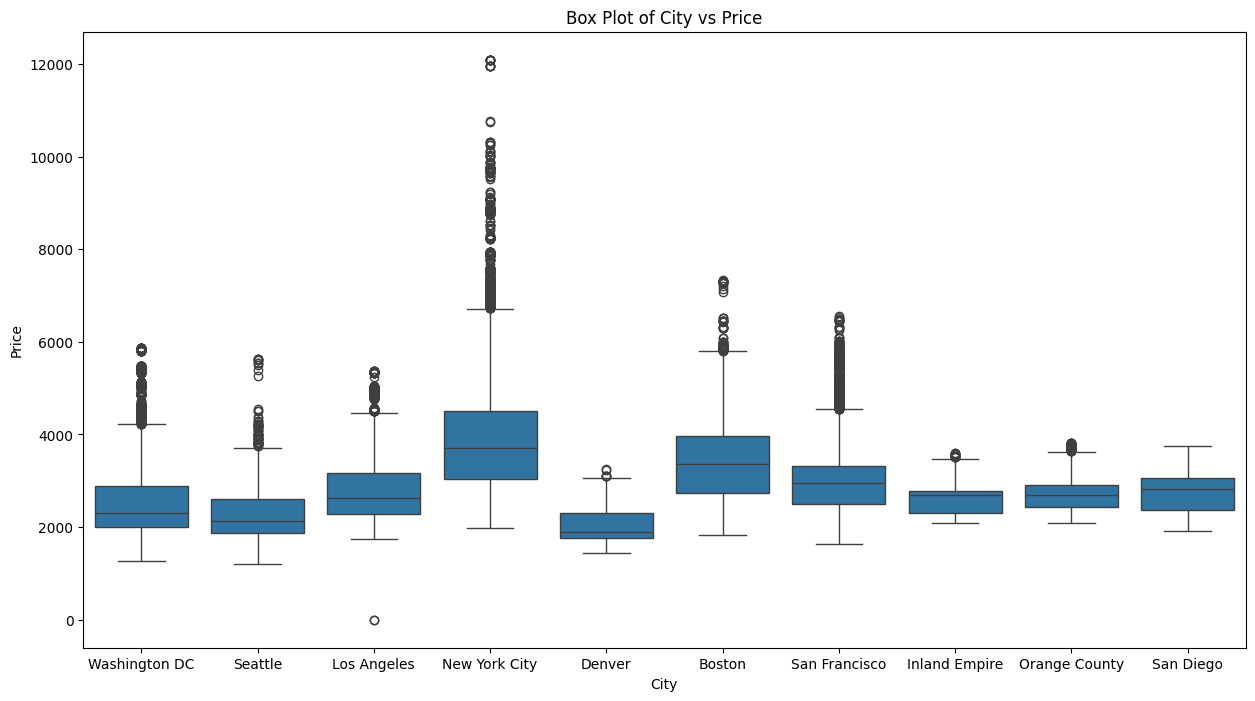

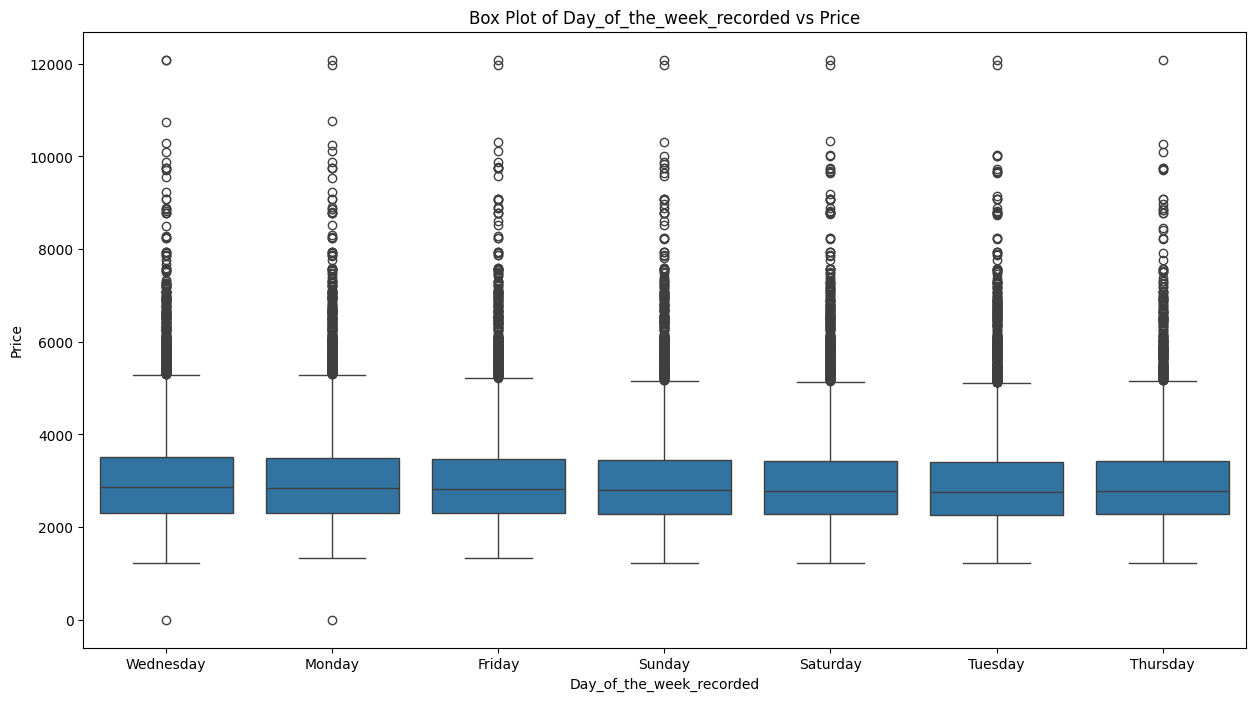

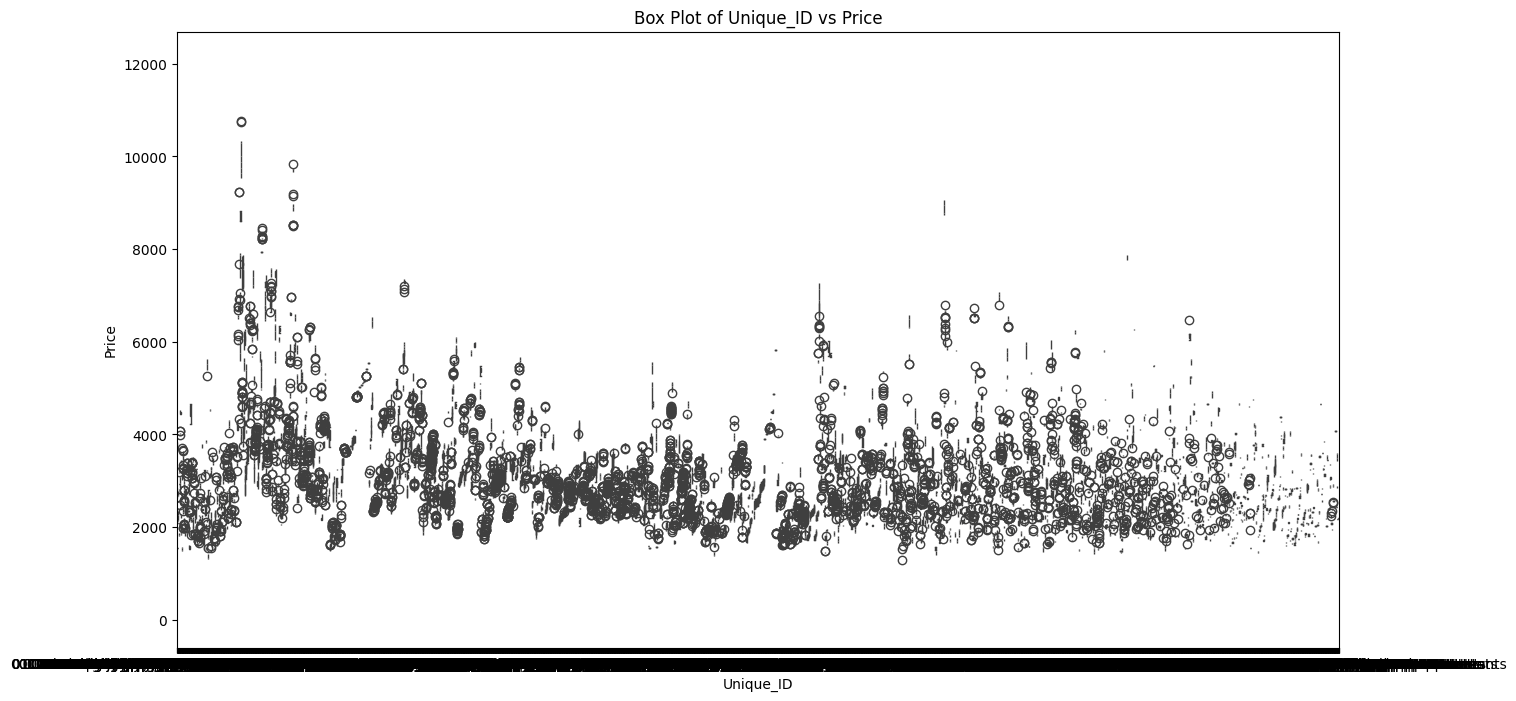

In [26]:
# Box plots for categorical features vs. Price
for feature in categorical_columns:
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df, x=feature, y='Price')
    plt.title(f'Box Plot of {feature} vs Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

In [27]:
# Calculate the covariance matrix
cov_matrix = df[numeric_features].cov()

# Display the covariance matrix
print(cov_matrix)

                             Price        Beds       Baths          sq.ft  \
Price                 1.048413e+06  329.037631  225.622917  129691.713831   
Beds                  3.290376e+02    0.501115    0.279976     152.507952   
Baths                 2.256229e+02    0.279976    0.234073      98.935770   
sq.ft                 1.296917e+05  152.507952   98.935770   62679.742998   
Floor                 2.804023e+03   -0.797002   -0.237493    -125.033213   
Units                -1.720505e+04   -0.349600   -1.973463    2043.432253   
Northern_Exposure     3.198497e+01    0.007494    0.010359       5.275935   
Southern_Exposure     1.397240e+01    0.017829    0.010168       5.269676   
Eastern_Exposure      2.214609e+01    0.010476    0.006025       4.413543   
Western_Exposure      1.593657e+01   -0.001334    0.002522       1.210624   
Balcony              -3.661114e+00    0.017317    0.007021      10.199402   
Walk_In_Closet        5.851351e+01    0.008817    0.010526       5.795094   

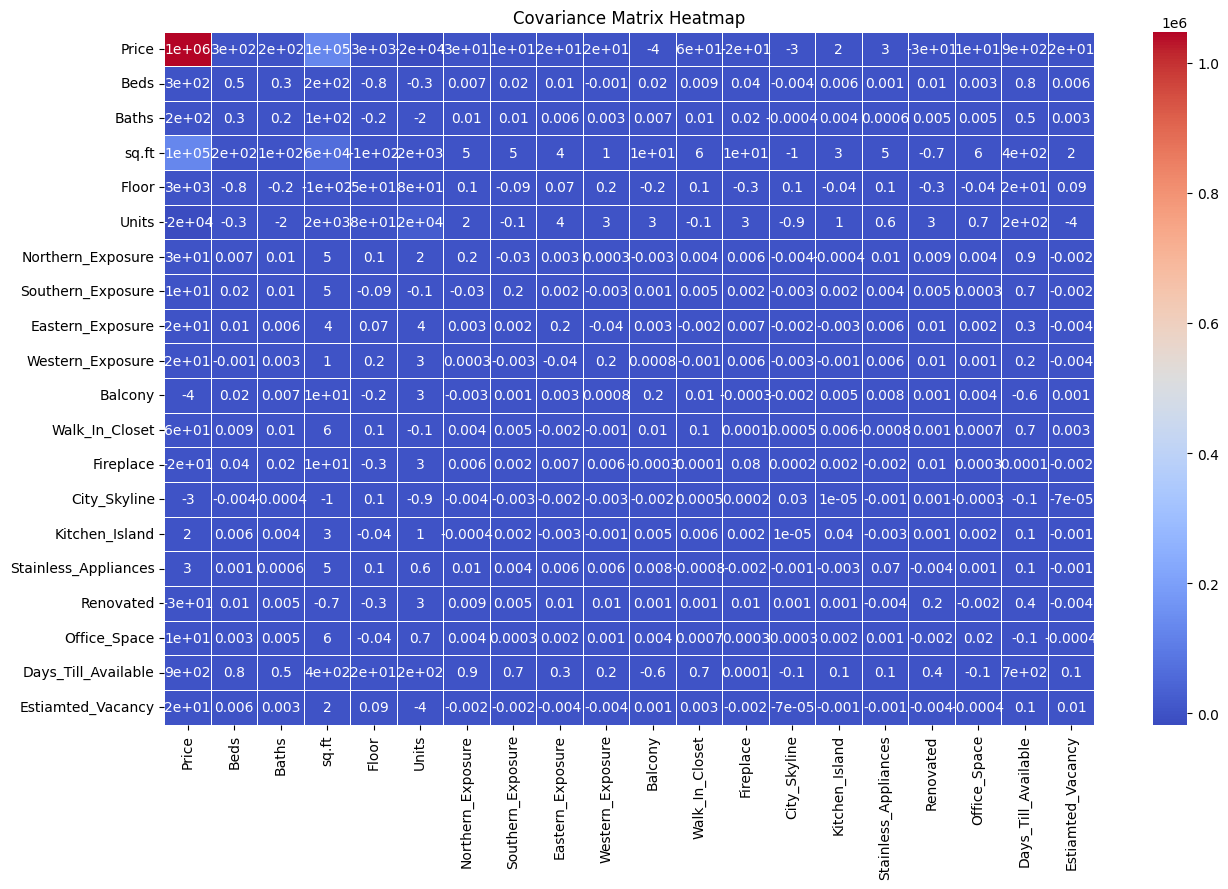

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of the covariance matrix
plt.figure(figsize=(15, 9))
sns.heatmap(cov_matrix, annot=True,fmt='.1g', cmap='coolwarm', linewidths=0.5)

plt.title('Covariance Matrix Heatmap')
plt.show()


From the covariance heatmap, we can draw several conclusions about the relationships between the features and the target variable (Price):

1. Strong Relationships:

 * Price and sq.ft: There is a strong positive covariance, indicating a direct relationship. As square footage, units and Floor increase, the price tends to increase significantly.
 * Price and Floor: A positive covariance suggests that as the floor increases, the price tends to increase. However, this relationship might need further exploration as it is not as strong as sq.ft, for example.

2. Moderate Relationships:

 * Price and Days_Till_Available, Price and Beds: Positive covariance indicates that as the number of beds and days till avaliable increase, the price tends to increase.
 * Price and Baths: Positive but weaker covariance compared to sq.ft and beds.

3. Weak Relationships:

 * Other features such as Office space, Easthern_Exposure, Westhern_Exposure,Northern_Exposure and Southern_Exposure and amenity features have much weaker covariance with Price. This suggests that these features might not be strong predictors on their own.

**Machine Learning Method Implications**

1. Useful Methods:

 * Linear Regression: Given the linear relationships, especially with features like sq.ft, Beds, and Baths, linear regression can be a suitable method.
 * Ridge and Lasso Regression: These regularization methods can help if there are many features with weak relationships, to penalize less important ones.
 * Tree-based Methods: Decision Trees, Random Forests, and Gradient Boosting can capture non-linear relationships and interactions between features, which might be beneficial given the mix of feature types.

2. Not Very Useful Methods:

 * K-Nearest Neighbors (KNN): May not be ideal for high-dimensional data and may not capture the linear relationships well.
 * Naive Bayes: Assumes independence between features, which is not the case here given the covariance.

**Preliminary Set of Features for ML Models**

Based on the covariance analysis, the preliminary set of features to include in the ML model should be:

Strong Predictors:

* sq.ft
* Floor


Moderate Predictors:

* Days_Till_Available
* Beds
* Baths

Potential Predictors:

* Northern_Exposure
* Southern_Exposure
* Eastern_Exposure
* Western_Exposure
* Balcony
* Walk_In_Closet
* Fireplace
* City_Skyline
* Kitchen_Island
* Stainless_Appliances
* Renovated
* Office_Space
These features show some degree of relationship with the target and can be further refined through feature engineering and selection methods.

Look at the distribution of some features

Text(0.5, 1.0, 'Distribution of Price')

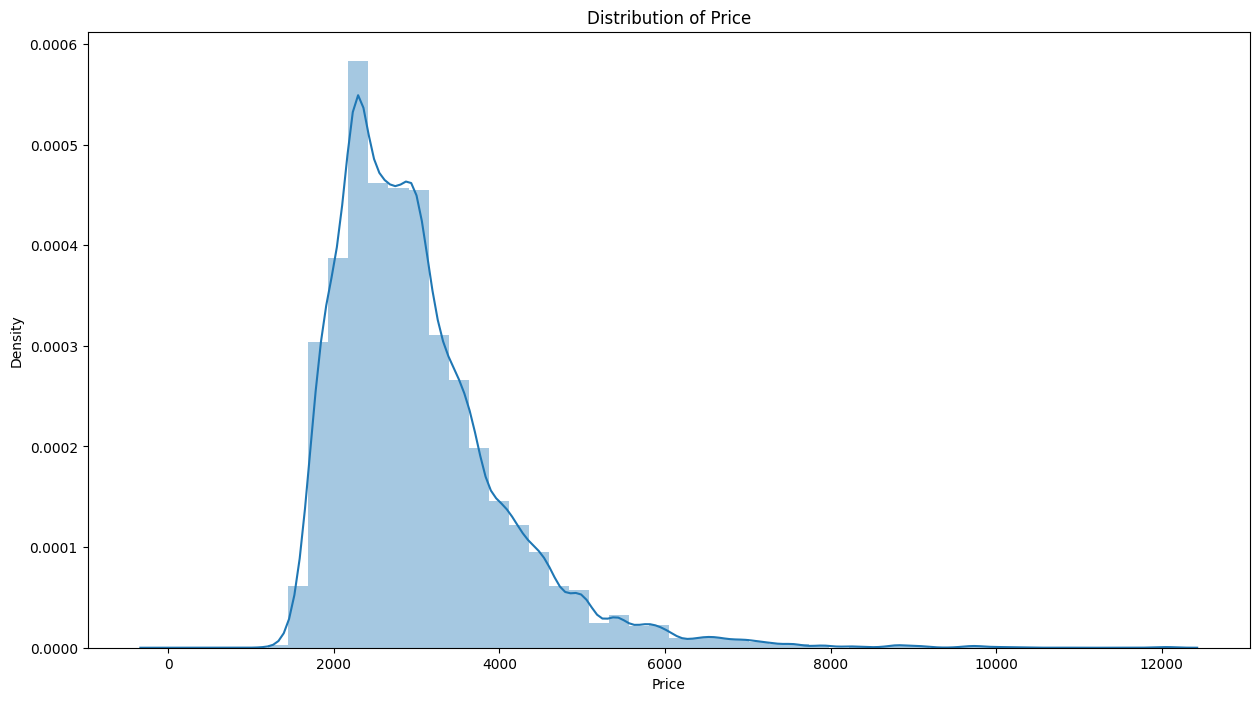

In [29]:
plt.figure(figsize=(15, 8))
sns.distplot(df.Price, kde=True)
plt.title('Distribution of Price')

Text(0.5, 1.0, 'Distribution of Beds')

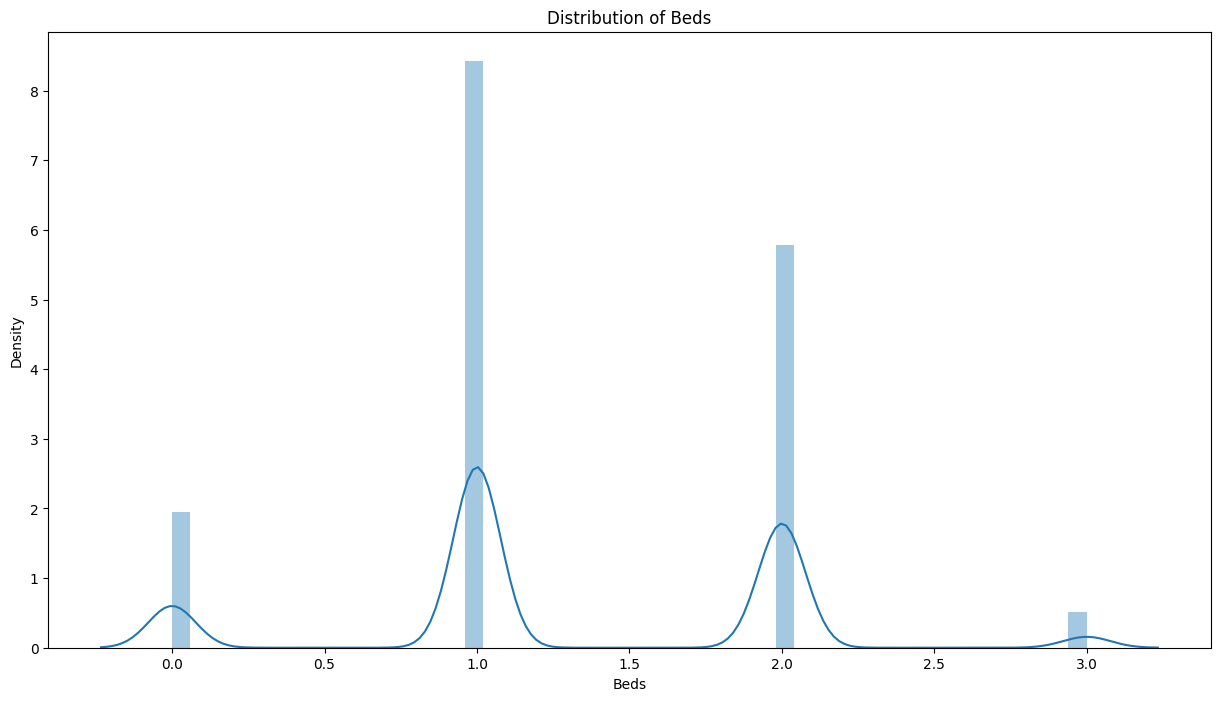

In [30]:
plt.figure(figsize=(15, 8))
sns.distplot(df.Beds, kde=True)
plt.title('Distribution of Beds')

Text(0.5, 1.0, 'Distribution of Baths')

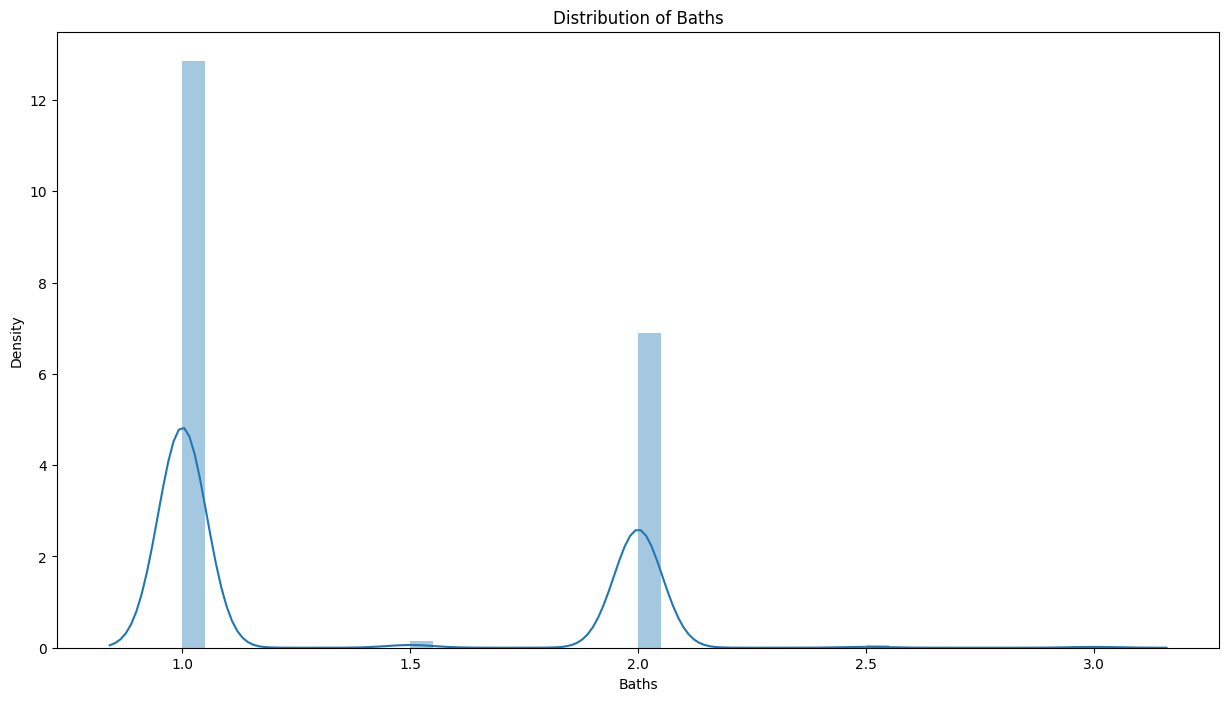

In [31]:
plt.figure(figsize=(15, 8))
sns.distplot(df.Baths, kde=True)
plt.title('Distribution of Baths')


Text(0.5, 1.0, 'Distribution of # of square feet')

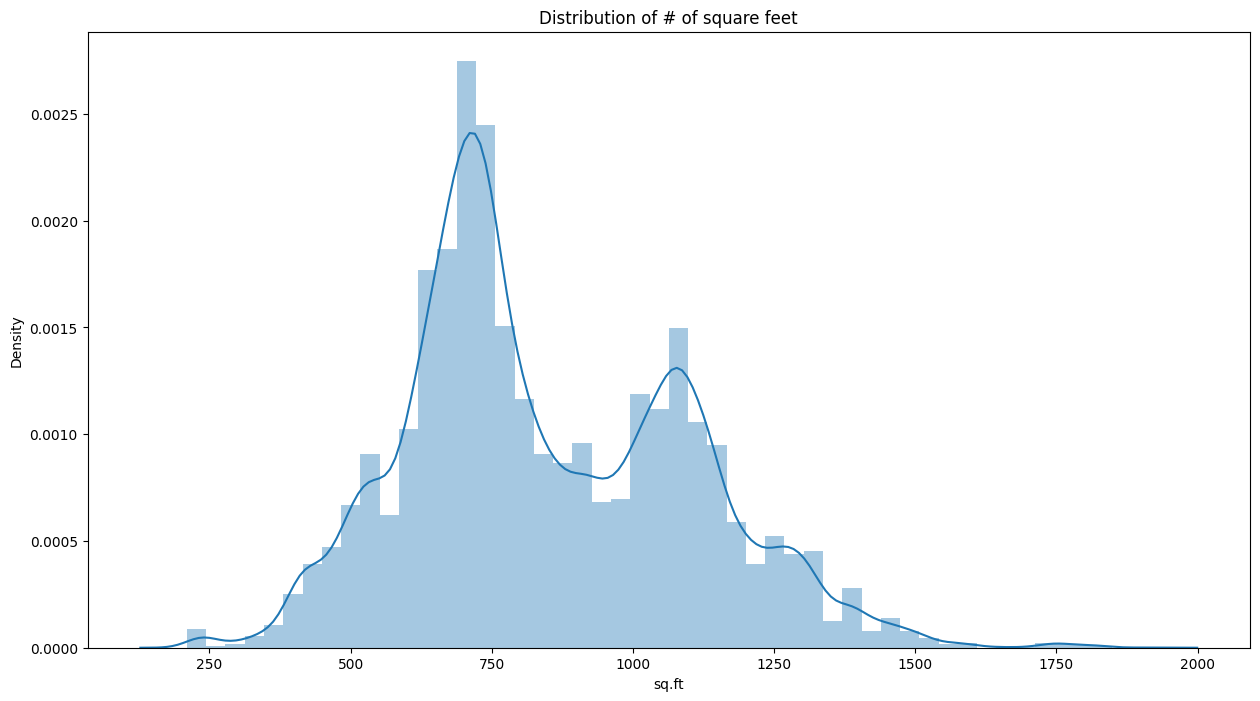

In [32]:
plt.figure(figsize=(15, 8))
sns.distplot(df['sq.ft'], kde=True)
plt.title('Distribution of # of square feet')


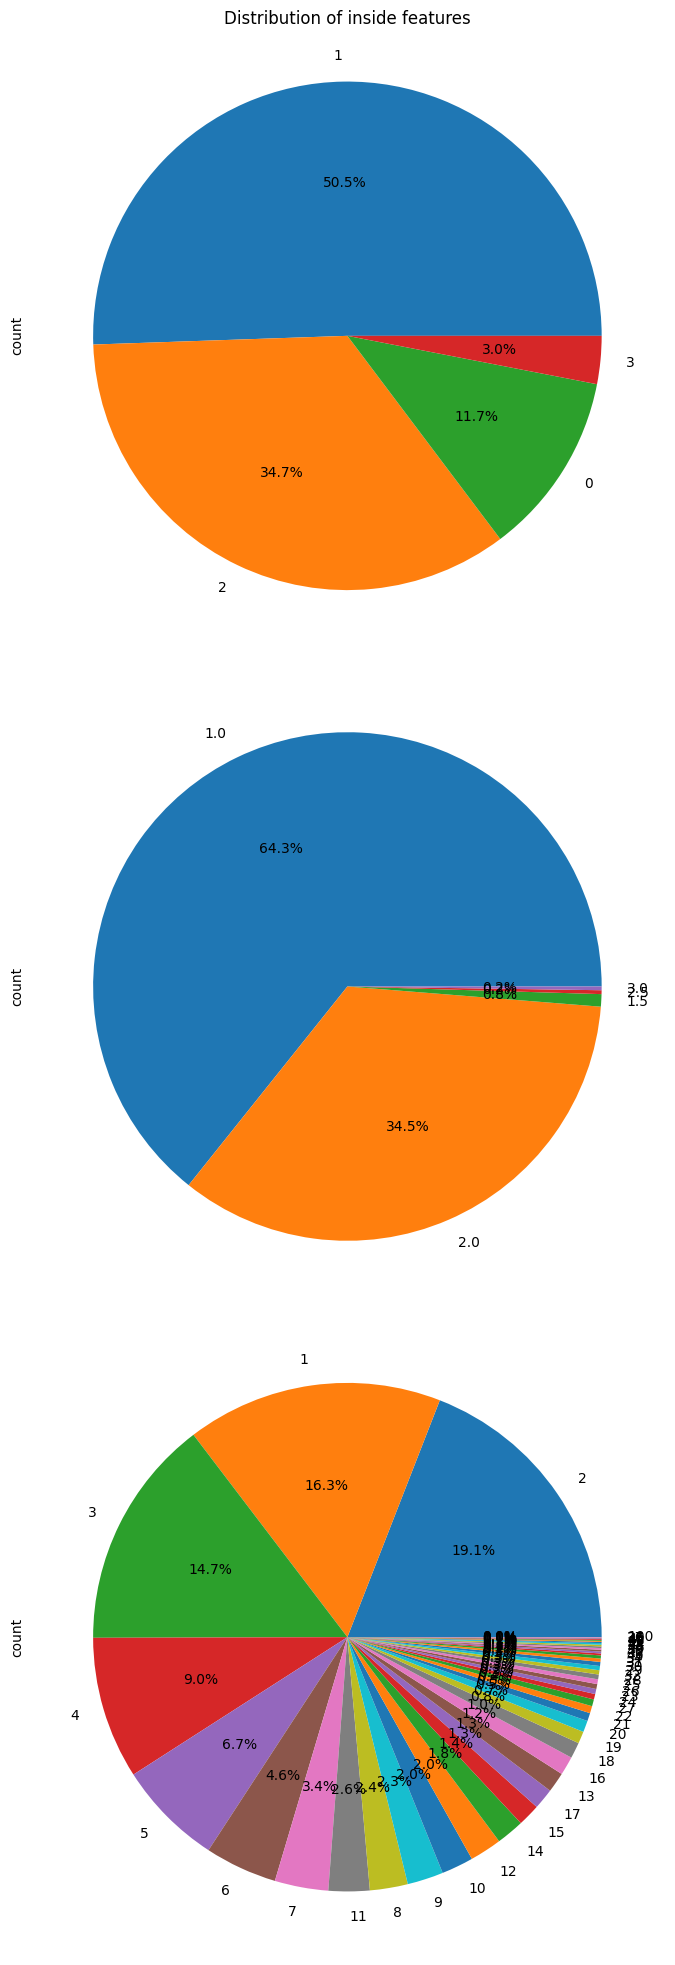

In [33]:
# Plot pie charts indicate features of inside
fig, axs = plt.subplots(nrows=3, figsize=(20, 20))

inside_features = ['Beds', 'Baths', 'Floor']

for i, feature in enumerate(inside_features):
    rows = i % 3
    pd.value_counts(df[feature]).plot.pie(autopct="%.1f%%", ax=axs[rows])

plt.suptitle('Distribution of inside features')
plt.tight_layout()

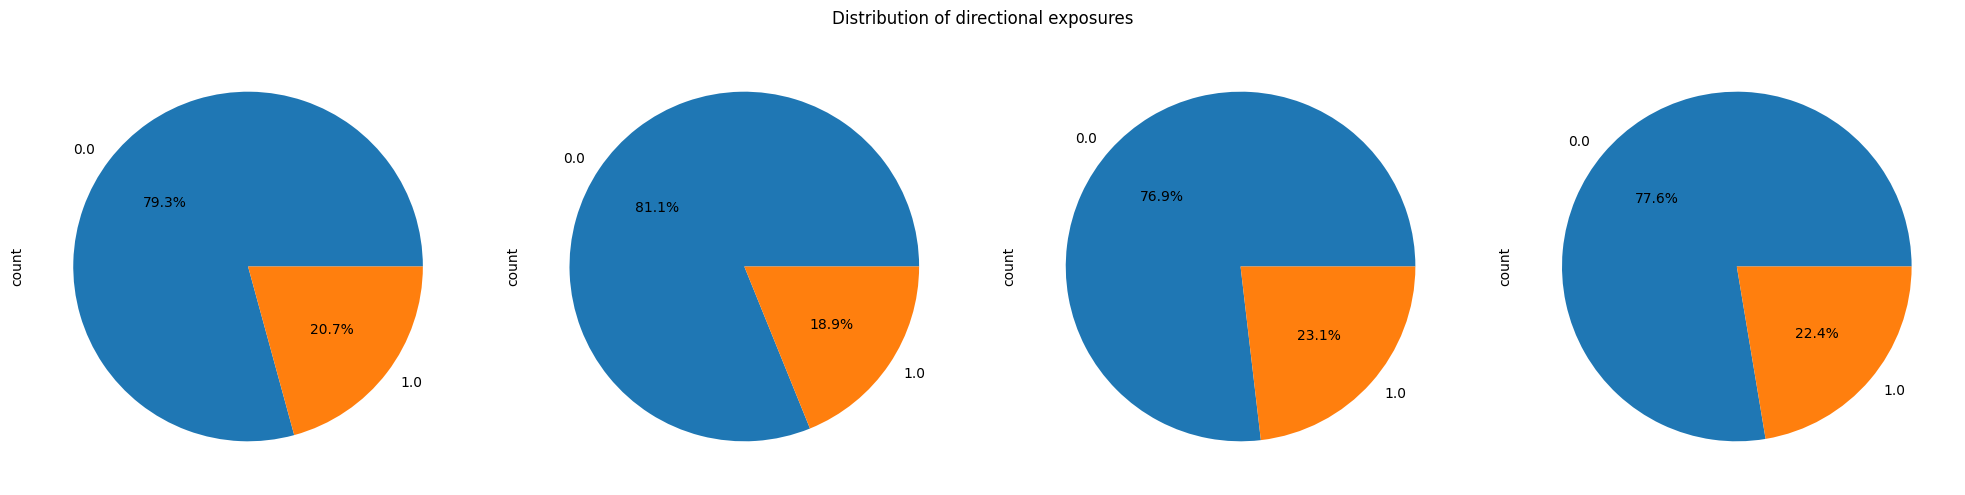

In [34]:
# Plot pie charts indicate features of inside
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))

exposures = ['Northern_Exposure', 'Southern_Exposure', 'Eastern_Exposure', 'Western_Exposure']

for i, exposure in enumerate(exposures):
    cols = i % 4
    pd.value_counts(df[exposure]).plot.pie(autopct="%.1f%%", ax=axs[cols])

plt.suptitle('Distribution of directional exposures')
plt.tight_layout()

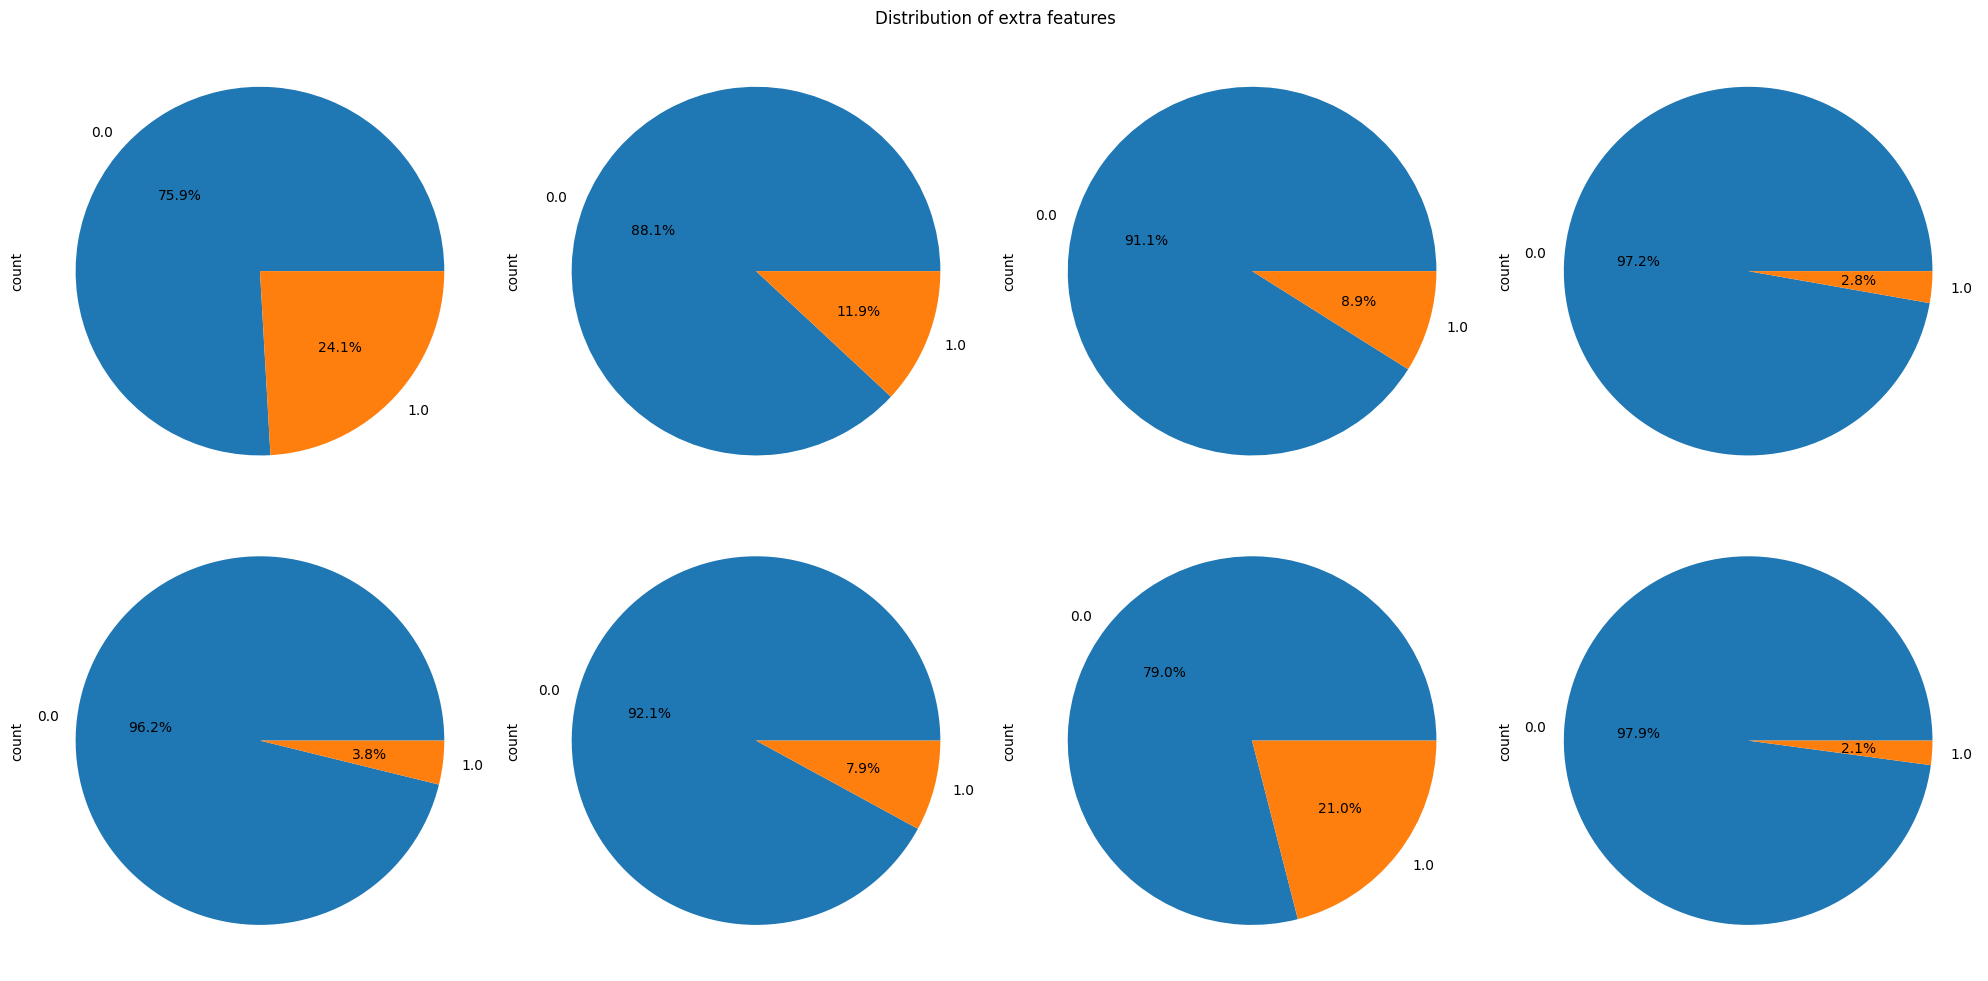

In [35]:
# Plot pie charts indicate extra features
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

extras = ['Balcony', 'Walk_In_Closet', 'Fireplace', 'City_Skyline', 'Kitchen_Island', 'Stainless_Appliances',
          'Renovated', 'Office_Space']

for i, extra in enumerate(extras):
    rows = int(i / 4)
    cols = i % 4
    pd.value_counts(df[extra]).plot.pie(autopct="%.1f%%", ax=axs[rows][cols])

plt.suptitle('Distribution of extra features')
plt.tight_layout()

## **Correlation analysis**

<Axes: title={'center': 'Correlation of residential features'}>

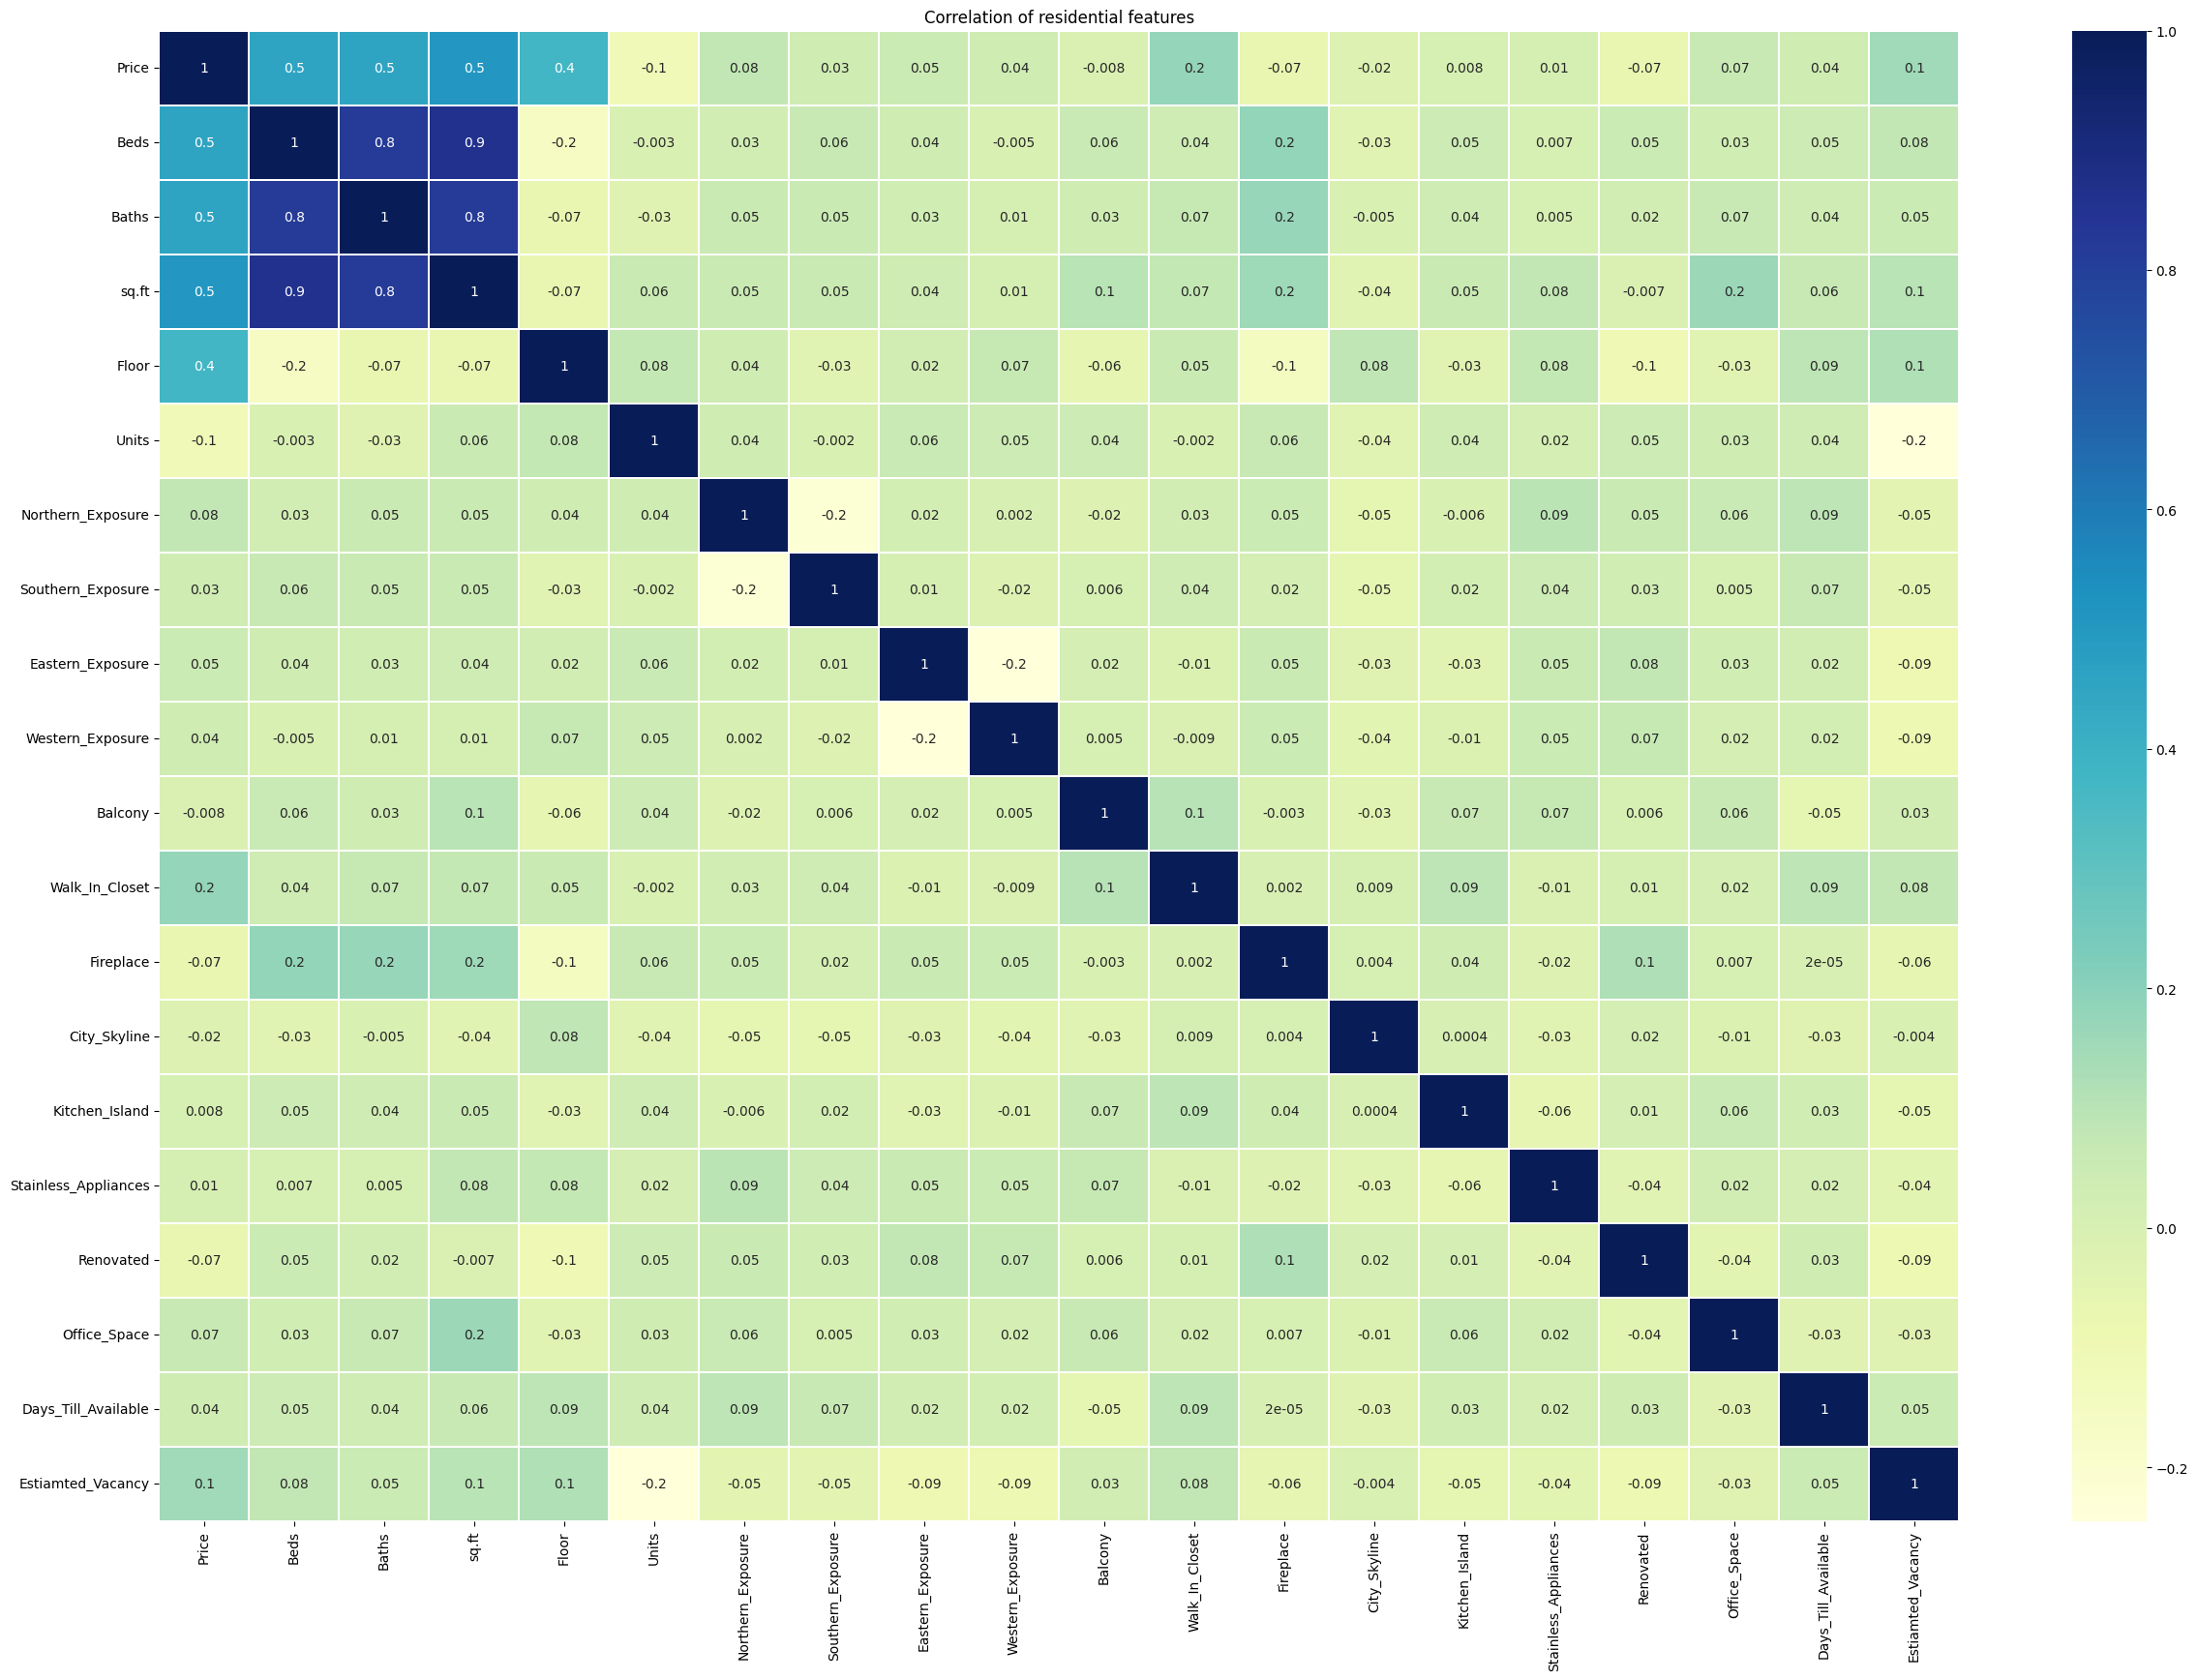

In [36]:
plt.figure(figsize=(30, 20))
plt.title('Correlation of residential features')
sns.heatmap(df[numeric_features].corr(), annot=True, fmt='.1g', linewidths=.3, cmap='YlGnBu')

1. Which features are correlated with each other:

* Beds and Baths (0.8): The number of bedrooms and bathrooms have a strong po
sitive correlation.
* Beds and sq.ft. (0.9): The number of bedrooms and the apartment's square footage also have a strong correlation.
* Baths and sq.ft. (0.8): The number of bathrooms and the square footage.
* Northern_Exposure, Southern_Exposure, Eastern_Exposure, and Western_Exposure: The exposure features have weak correlations with each other.
* Fireplace and Beds (0.2), Baths (0.2), sq.ft. (0.2): The presence of a fireplace has a moderate positive correlation with the number of bedrooms, bathrooms, and square footage.
* Kitchen_Island and sq.ft. (0.1): The presence of a kitchen island has a weak positive correlation with the square footage.

2. Which features have a strong correlation with the target feature (Price):

* Beds (0.5): The number of bedrooms has a moderate positive correlation with price.
* Baths (0.5): The number of bathrooms also has a moderate positive correlation with price.
* sq.ft. (0.5): The square footage has a moderate positive correlation with price.
* Floor (0.4): The floor has a moderate positive correlation with price.
* Fireplace (0.2): The presence of a fireplace has a weak positive correlation with price.

3. Which correlation methods were used and why:

* The Pearson correlation method was used, as indicated by the use of numerical correlation values ranging from -1 to 1.
* Reasons for using Pearson correlation:
  * Pearson correlation measures the linear relationship between two variables, which is convenient for assessing direct dependencies.
  * The features in the dataset are quantitative, making Pearson correlation an appropriate method.

## **Missing values**

In [37]:
df.isnull().sum()

Price                          0
Beds                           0
Baths                          0
sq.ft                          0
Floor                          0
Move_in_date                 788
building_id                  852
unit_id                      852
URL                            0
Day_Recorded                   0
Amenity                        0
Apartment Name                 0
Address                        0
City                           0
Units                          0
Northern_Exposure           2491
Southern_Exposure           2491
Eastern_Exposure            2491
Western_Exposure            2491
Balcony                     2491
Walk_In_Closet              2491
Fireplace                   2491
City_Skyline                2491
Kitchen_Island              2491
Stainless_Appliances        2491
Renovated                   2491
Office_Space                2491
Days_Till_Available          788
Day_of_the_week_recorded       0
Unique_ID                    852
Estiamted_

**Identifying Missing Values**

* Move_in_date: Missing 788 values
* building_id: Missing 852 values
* unit_id: Missing 852 values
* Northern_Exposure: Missing 2491 values
* Southern_Exposure: Missing 2491 values
* Eastern_Exposure: Missing 2491 values
* Western_Exposure: Missing 2491 values
* Balcony: Missing 2491 values
* Fireplace: Missing 2491 values
* City_Skyline: Missing 2491 values
* Kitchen_Island: Missing 2491 values
* Stainless_Appliances: Missing 2491 values
* Renovated: Missing 2491 values
* Office_Space: Missing 2491 values
* Walk_In_Closet: Missing 2491 values
* Days_Till_Available: Missing 788 values
* Unique_ID: Missing 852 values


**Handling Missing Values**

1. Move_in_date

* Imputation Strategy:
 * Column Move_in_date has some missing values, but there is another Date Column which is Day_Recorded, which shows that when the sale is recorded and there is another columns Days_Till_Available(which has missing values too, but we can impute them with most frequent strategy), which shows that when they move in. So if we add the Days Recorded in Days Till Available, we will eventually get the columns Move_in_date, without any Null values.

1. building_id and unit_id

Since building_id and unit_id are likely categorical or identifier columns:

* Imputation Strategy:
 * If these columns are not crucial for your analysis, you might consider dropping them if the missing data cannot be reliably inferred.
 * If they are crucial, impute the mode (most common value).

 2. Northern_Exposure, Southern_Exposure, Eastern_Exposure
Western_Exposure, Balcony, Walk_In_Closet, Fireplace
City_Skyline, Kitchen_Island, Stainless_Appliances, Renovated
Office_Space, Days_Till_Available

* Imputation Strategy:
 * Since all columns are numeric features indicating the presence of the presence of any needs, impute with the mode (most common value).

 3. Unique_ID

* Imputation Strategy:
 * If Unique_ID is a unique identifier for each record, missing values might indicate a significant issue. But there are duplicates because of that we can apply imputing with the mode (most common value).


**Assessing the Quality of the Data**

Based on the extent of missing data, the overall quality can be assessed. Here’s a summary of the assessment:

* Columns with missing data:

 * Northern_Exposure, Southern_Exposure, Eastern_Exposure
Western_Exposure, Balcony, Walk_In_Closet, Fireplace
City_Skyline, Kitchen_Island, Stainless_Appliances, Renovated
Office_Space, Days_Till_Available: 2491 missing values out of the total rows in each column.

* Move_in_date, Days_Till_Available: 788 missing values out of the total rows in each column.

* building_id, unit_id, and Unique_ID: 852 missing values out of the total rows in each column.

The total number of rows is 62 810, then:

* Northern_Exposure, Southern_Exposure, Eastern_Exposure
Western_Exposure, Balcony, Walk_In_Closet, Fireplace
City_Skyline, Kitchen_Island, Stainless_Appliances, Renovated
Office_Space have about 4% missing values each.

* Move_in_date, Days_Till_Available have about 1% missing values each.

* building_id, unit_id, and Unique_ID have about 1% missing values each.

Overall Quality Assessment:

* `Bad`: If more than 30% of the data is missing in multiple crucial columns.
* `Good`: If around 10-30% of the data is missing but manageable with imputation.
* `Excellent`: If less than 10% of the data is missing and there are no other major issues.

The missing values in Northern_Exposure, Southern_Exposure, Eastern_Exposure
Western_Exposure, Balcony, Walk_In_Closet, Fireplace
City_Skyline, Kitchen_Island, Stainless_Appliances, Renovated
Office_Space, building_id, unit_id, Move_in_date, Days_Till_Available and Unique_ID are insignificant, so the data quality can be considered `Excellent`.



In [38]:
New_date = []

df['Day_Recorded'] = pd.to_datetime(df['Day_Recorded'])

#imputing missing values with mode strategy to achive correct calculations of the date
df['Days_Till_Available'] = df['Days_Till_Available'].fillna(df['Days_Till_Available'].mode()[0])

for i in range(df.shape[0]):
    Move_date = df.Day_Recorded[i]+dt.timedelta(days=df.Days_Till_Available[i])
    New_date.append(Move_date)

df['Move_in_date(new)'] = pd.to_datetime(New_date).strftime('%Y-%m-%d')


In [39]:
df[['Move_in_date','Move_in_date(new)']]

Move_in_date Move_in_date(new)
0       2021-09-02        2021-09-02
1       2021-09-13        2021-09-13
2       2021-10-08        2021-10-08
3       2021-09-17        2021-09-17
4       2021-10-05        2021-10-05
...            ...               ...
62805   2021-06-29        2021-06-29
62806   2021-07-17        2021-07-17
62807   2021-07-27        2021-07-27
62808   2021-08-21        2021-08-21
62809   2021-07-21        2021-07-21

[62810 rows x 2 columns]

In [40]:
df['Move_in_date(new)'].isnull().sum()

0

Here We can see Old Column Move in date is completely identical with New Move In date without any null values, so we do not need old column.


In [41]:
df.drop('Move_in_date',axis=1,inplace=True)

Sorted data by 'Day_Recorded' like time series

In [42]:
df.sort_values(by='Day_Recorded', inplace=True)

In [43]:
df['Amenity'] = df['Amenity'].fillna(df['Amenity'].mode()[0])
df['Northern_Exposure']= df['Northern_Exposure'].fillna(df.Northern_Exposure.mode()[0])
df['Southern_Exposure']= df['Southern_Exposure'].fillna(df.Southern_Exposure.mode()[0])
df['Eastern_Exposure']= df['Eastern_Exposure'].fillna(df.Eastern_Exposure.mode()[0])
df['Western_Exposure']= df['Western_Exposure'].fillna(df.Western_Exposure.mode()[0])
df['Balcony']= df['Balcony'].fillna(df.Balcony.mode()[0])
df['Walk_In_Closet']= df['Walk_In_Closet'].fillna(df.Walk_In_Closet.mode()[0])
df['Fireplace']= df['Fireplace'].fillna(df.Fireplace.mode()[0])
df['City_Skyline']= df['City_Skyline'].fillna(df.City_Skyline.mode()[0])
df['Kitchen_Island']= df['Kitchen_Island'].fillna(df.Kitchen_Island.mode()[0])
df['Stainless_Appliances']= df['Stainless_Appliances'].fillna(df.Stainless_Appliances.mode()[0])
df['Renovated']= df['Renovated'].fillna(df.Renovated.mode()[0])
df['Office_Space']= df['Office_Space'].fillna(df.Office_Space.mode()[0])
df['building_id'] = df['building_id'].fillna(df['building_id'].mode()[0])
df['unit_id'] = df['unit_id'].fillna(df['unit_id'].mode()[0])
df['Unique_ID'] = df['Unique_ID'].fillna(df['Unique_ID'].mode()[0])

# Check remaining missing values
print(df.isnull().sum())

# Assess data quality
missing_percentage = (df.isnull().sum() / len(df)) * 100
data_quality = 'Excellent' if missing_percentage.max() < 10 else 'Good' if missing_percentage.max() < 30 else 'Bad'

print()

print(f'Data Quality: {data_quality}')

Price                       0
Beds                        0
Baths                       0
sq.ft                       0
Floor                       0
building_id                 0
unit_id                     0
URL                         0
Day_Recorded                0
Amenity                     0
Apartment Name              0
Address                     0
City                        0
Units                       0
Northern_Exposure           0
Southern_Exposure           0
Eastern_Exposure            0
Western_Exposure            0
Balcony                     0
Walk_In_Closet              0
Fireplace                   0
City_Skyline                0
Kitchen_Island              0
Stainless_Appliances        0
Renovated                   0
Office_Space                0
Days_Till_Available         0
Day_of_the_week_recorded    0
Unique_ID                   0
Estiamted_Vacancy           0
Move_in_date(new)           0
dtype: int64

Data Quality: Excellent


## **Data transformation methods for ML-ready datasets**

1. Price, Beds, Baths, sq.ft, Floor, Days_Till_Available, Units, Estiamted_Vacancy: These are numerical features. Depending on the our model using, we might need to normalize or standardize these features. We will use Standard Scaling.
2. Move_in_date, Day_Recorded: These are date features. We transform these into ordinal numbers (e.g., number of days since a certain date) and extract components like day of the week, month, year.
3. Apartment Name, Address, Amenity, building_id, unit_id, Unique_ID: They are a text feature. We will use word embeddings technique to transform this feature into a numerical format.
4. URL: This feature might not provide useful information for a model as it is. We will drop this feature.
5. Northern_Exposure, Southern_Exposure, Eastern_Exposure, Western_Exposure, Balcony, Walk_In_Closet, Fireplace, City_Skyline, Kitchen_Island, Stainless_Appliances, Renovated, Office_Space: These are binary features (0/1). They might not need any transformation.
6. City, Day_of_the_week_recorded: They are a categorical feature. We will apply one-hot encoding or label encoding (if there is an inherent order).

In [44]:
df[['Amenity', 'Apartment Name', 'Address', 'City', 'Day_of_the_week_recorded']]

Amenity  \
62809                                   eastern southern   
62797                                   southern western   
62798                                   northern western   
62799                                         eastern na   
62800                                   northern western   
...                                                  ...   
1439     view of downtown san francisco western exposure   
1440             eastern exposure view of berkeley hills   
1441      corner unit eastern exposure northern exposure   
1427                                    eastern exposure   
0      hard surface flooring throughout northern expo...   

                       Apartment Name  \
62809     courthouse plaza apartments   
62797     courthouse plaza apartments   
62798     courthouse plaza apartments   
62799     courthouse plaza apartments   
62800     courthouse plaza apartments   
...                               ...   
1439        parc on powell apartments   
1440        parc on powell apartments   
1441        parc on powell apartments   
1427   artistry emeryville apartments   
0                1210 mass apartments   

                                              Address           City  \
62809         2250 clarendon blvd. arlington va 22201  Washington DC   
62797         2250 clarendon blvd. arlington va 22201  Washington DC   
62798         2250 clarendon blvd. arlington va 22201  Washington DC   
62799         2250 clarendon blvd. arlington va 22201  Washington DC   
62800         2250 clarendon blvd. arlington va 22201  Washington DC   
...                                               ...            ...   
1439           1333 powell street emeryville ca 94608  San Francisco   
1440           1333 powell street emeryville ca 94608  San Francisco   
1441           1333 powell street emeryville ca 94608  San Francisco   
1427          6401 shellmound st. emeryville ca 94608  San Francisco   
0      1210 massachusetts ave, nw washington dc 20005  Washington DC   

      Day_of_the_week_recorded  
62809                   Sunday  
62797                   Sunday  
62798                   Sunday  
62799                   Sunday  
62800                   Sunday  
...                        ...  
1439                 Wednesday  
1440                 Wednesday  
1441                 Wednesday  
1427                 Wednesday  
0                    Wednesday  

[62810 rows x 5 columns]

In [45]:
df.drop('URL',axis=1,inplace=True)

Enoding categorical features using one-hot encoding. it is the most convenient approach, because there are not a lot of variables in the column `City` and also we can't arrange them.

In [46]:
cities = pd.get_dummies(df.City, dtype=float).drop(df.City.value_counts().tail(1).index[0],axis=1)
cities.head()

Boston  Denver  Los Angeles  New York City  Orange County  San Diego  \
62809     0.0     0.0          0.0            0.0            0.0        0.0   
62797     0.0     0.0          0.0            0.0            0.0        0.0   
62798     0.0     0.0          0.0            0.0            0.0        0.0   
62799     0.0     0.0          0.0            0.0            0.0        0.0   
62800     0.0     0.0          0.0            0.0            0.0        0.0   

       San Francisco  Seattle  Washington DC  
62809            0.0      0.0            1.0  
62797            0.0      0.0            1.0  
62798            0.0      0.0            1.0  
62799            0.0      0.0            1.0  
62800            0.0      0.0            1.0

In [47]:
df = pd.concat([df,cities],axis=1)
df.drop(['City'], axis=1, inplace=True)

For Day_of_the_week_recorded using label encoding. We have arranged the values in the order of the most common.

In [48]:
df['Day_of_the_week_recorded'].value_counts()

Day_of_the_week_recorded
Tuesday      9798
Saturday     9530
Friday       9515
Sunday       9510
Monday       9023
Wednesday    8841
Thursday     6593
Name: count, dtype: int64

In [49]:
#label encoding
label_encoding = {'Tuesday': 1, 'Saturday': 2,'Friday': 3, 'Sunday': 4, 'Monday': 5, 'Wednesday': 6, 'Thursday': 7}
df['Day_of_the_week_recorded'] = df['Day_of_the_week_recorded'].apply(lambda x : label_encoding.get(x))

Encoding text features using embeddings(Word2Vec is a popular technique for natural language processing (NLP) that involve using neural networks to create word embeddings. These embeddings are densevector representations of words that capture their meanings and relationships based on the context in which they appear in a large corpus of text.) because they have a lot of unique values.

In [50]:
df[['unit_id','Address','Apartment Name', 'Unique_ID', 'building_id', 'Amenity']]

unit_id                                         Address  \
62809     101         2250 clarendon blvd. arlington va 22201   
62797     101         2250 clarendon blvd. arlington va 22201   
62798     101         2250 clarendon blvd. arlington va 22201   
62799     101         2250 clarendon blvd. arlington va 22201   
62800     101         2250 clarendon blvd. arlington va 22201   
...       ...                                             ...   
1439      332          1333 powell street emeryville ca 94608   
1440      402          1333 powell street emeryville ca 94608   
1441      206          1333 powell street emeryville ca 94608   
1427     7111         6401 shellmound st. emeryville ca 94608   
0        0507  1210 massachusetts ave, nw washington dc 20005   

                       Apartment Name  \
62809     courthouse plaza apartments   
62797     courthouse plaza apartments   
62798     courthouse plaza apartments   
62799     courthouse plaza apartments   
62800     courthouse plaza apartments   
...                               ...   
1439        parc on powell apartments   
1440        parc on powell apartments   
1441        parc on powell apartments   
1427   artistry emeryville apartments   
0                1210 mass apartments   

                                         Unique_ID building_id  \
62809  001507thereserveatclarendoncentreapartments           1   
62797  001507thereserveatclarendoncentreapartments           1   
62798  001507thereserveatclarendoncentreapartments           1   
62799  001507thereserveatclarendoncentreapartments           1   
62800  001507thereserveatclarendoncentreapartments           1   
...                                            ...         ...   
1439                    a332parconpowellapartments           A   
1440                    b402parconpowellapartments           B   
1441                    a206parconpowellapartments           A   
1427            077111artistryemeryvilleapartments          07   
0                         0105071210massapartments          01   

                                                 Amenity  
62809                                   eastern southern  
62797                                   southern western  
62798                                   northern western  
62799                                         eastern na  
62800                                   northern western  
...                                                  ...  
1439     view of downtown san francisco western exposure  
1440             eastern exposure view of berkeley hills  
1441      corner unit eastern exposure northern exposure  
1427                                    eastern exposure  
0      hard surface flooring throughout northern expo...  

[62810 rows x 6 columns]

Checking if the column has some not string rows.

In [51]:
if pd.api.types.is_string_dtype(df['Amenity']):
    print("Amenity is string")
else:
    print("Amenity is not string")

Amenity is string


In [52]:
# Text preprocessing
df['Amenity_processed'] = df['Amenity'].apply(lambda x: simple_preprocess(x))


# Learning the Word2Vec model
model_Amenity = Word2Vec(sentences=df['Amenity_processed'], vector_size=10, window=5, min_count=1, workers=4)

# Getting vectors for words
word_vectors_Amenity = model_Amenity.wv

# Getting the average vector for each document
df['Amenity_vector'] = df['Amenity_processed'].apply(lambda x: sum([word_vectors_Amenity[word] for word in x if word in word_vectors_Amenity] or [0]) / len(x))


In [53]:
if pd.api.types.is_string_dtype(df['Unique_ID']):
    print("Unique_ID is string")
else:
    print("Unique_ID is not string")

Unique_ID is string


In [54]:
# Splitting each line into two tokens: numbers and letters
def tokenize(address):
    match = re.match(r"(\d+)([a-zA-Z]+)", address)
    if match:
        return [match.group(1), match.group(2)]
    return [address]

df['Unique_ID_processed'] = df['Unique_ID'].apply(tokenize)

tokens = df['Unique_ID_processed'].tolist()

# Creating a Word2Vec Model

model = Word2Vec(sentences=tokens, vector_size=2, window=5, min_count=1, workers=4)

# Getting vectors for words
word_vectors = model.wv

# we get vectors for all tokens and combine them
df['Unique_ID_vector'] = df['Unique_ID_processed'].apply(lambda x: sum([word_vectors[word] for word in x if word in word_vectors] or [0]) / len(x))


In [55]:
if pd.api.types.is_string_dtype(df['building_id']):
    print("building_id is string")
else:
    print("building_id is not string")

building_id is string


In [56]:
# Convert each value into a list of one element (to be suitable for Word2Vec)
df['building_id_processed'] = df['building_id'].apply(lambda x: [x])

sentences = df['building_id_processed'].tolist()

# Learning the Word2Vec model
model = Word2Vec(sentences=sentences, vector_size=1, window=5, min_count=1, workers=4)

# Getting vectors for words
word_vectors = model.wv

# Getting vectors for all values and adding them to the Data Frame
df['building_id_vector'] = df['building_id'].apply(lambda x: word_vectors[x])

In [57]:
if pd.api.types.is_string_dtype(df['unit_id']):
    print("unit_id is string")
else:
    print("unit_id is not string")

unit_id is string


In [58]:
# Convert each value into a list of one element (to be suitable for Word2Vec)
df['unit_id_processed'] = df['unit_id'].apply(lambda x: [x])

sentences = df['unit_id_processed'].tolist()

# Learning the Word2Vec model
model = Word2Vec(sentences=sentences, vector_size=1, window=5, min_count=1, workers=4)

# Getting vectors for words
word_vectors = model.wv

# Getting vectors for all values and adding them to the Data Frame
df['unit_id_vector'] = df['unit_id'].apply(lambda x: word_vectors[x])

In [59]:
if pd.api.types.is_string_dtype(df['Address']):
    print("Address is string")
else:
    print("Address is not string")

Address is string


In [60]:
# Text preprocessing
df['Address_processed'] = df['Address'].apply(lambda x: simple_preprocess(x))

# Learning the Word2Vec model
model = Word2Vec(sentences=df['Address_processed'], vector_size=3, window=5, min_count=1, workers=4)

# Getting vectors for words
word_vectors = model.wv

# Getting the average vector for each document
df['Address_vector'] = df['Address_processed'].apply(lambda x: sum([word_vectors[word] for word in x if word in word_vectors] or [0]) / len(x))


In [61]:
if pd.api.types.is_string_dtype(df['Apartment Name']):
    print("Apartment Name is string")
else:
    print("Apartment Name is not string")

Apartment Name is string


In [62]:
# Dividing lines into words
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

df['Apartment_Name_processed'] = df['Apartment Name'].apply(tokenize)


sentences = df['Apartment_Name_processed'].tolist()

# Creating and training a Word2Vec model
model = Word2Vec(sentences=sentences, vector_size=3, window=5, min_count=1, workers=4)

# Getting vectors for words
word_vectors = model.wv

# Getting the average vector for each document
df['Apartment Name_vector'] = df['Apartment_Name_processed'].apply(lambda x: sum([word_vectors[word] for word in x if word in word_vectors] or [0]) / len(x))

Drop processed and origin features

In [63]:
df.drop(['building_id','building_id_processed',	'unit_id','unit_id_processed', 'Amenity','Apartment Name','Apartment_Name_processed', 'Address','Address_processed', 'Amenity_processed', 'Unique_ID', 'Unique_ID_processed'], axis=1, inplace=True)

Doing transformation with Dates

In [64]:
df["Move_in_date(new)"] = pd.to_datetime(df["Move_in_date(new)"])
df["Day_Recorded"] = pd.to_datetime(df["Day_Recorded"])

We can delete the column `Day_Recorded` because this date can be calculated using columns `Move_in_date(new)` and `Days_Till_Available`

In [65]:
#extract date and time
df["Move_in_date_day"] = df["Move_in_date(new)"].dt.day
df["Move_in_date_month"] = df["Move_in_date(new)"].dt.month
df["Move_in_date_year"] = df["Move_in_date(new)"].dt.year

df.drop(["Move_in_date(new)","Day_Recorded"], axis=1, inplace=True)

 Apply Standard Scaling for numeric columns except the target - `Price`, and binary columns: `Northern_Exposure`, `Southern_Exposure`, `Eastern_Exposure`,
`Western_Exposure`, `Balcony`, `Walk_In_Closet`, `Fireplace`,
`City_Skyline`, `Kitchen_Island`, `Stainless_Appliances`, `Renovated`,
`Office_Space`, `Boston`,
`Denver`, `Los Angeles`, `New York City`, `Orange County`, `San Diego`,
`San Francisco`, `Seattle`, `Washington DC`

In [66]:
for_scaling = ['Beds', 'Baths', 'sq.ft', 'Floor', 'Days_Till_Available', 'Units', 'Estiamted_Vacancy', 'Move_in_date_day', 'Move_in_date_month', 'Move_in_date_year']
scaler = StandardScaler()
scaler.fit(df[for_scaling])
df[for_scaling]=scaler.transform(df[for_scaling])

Processing vectors columns into separate single value columns to build a model further.

In [67]:
df[['Amenity_vector',	'Unique_ID_vector',	'building_id_vector',	'Address_vector',	'Apartment Name_vector']]

Amenity_vector  \
62809  [0.12757507, 0.7421304, -0.91428447, -0.130297...   
62797  [0.41457832, 0.34550613, -1.4002131, 0.2342863...   
62798  [0.34134167, 0.3374015, -1.5639861, 0.19462924...   
62799  [-0.06198954, 0.41180855, -0.46487156, -0.2091...   
62800  [0.34134167, 0.3374015, -1.5639861, 0.19462924...   
...                                                  ...   
1439   [0.52570724, -0.21231811, -0.52781683, 0.51370...   
1440   [-0.0012295395, 0.48371252, -0.42389664, 0.945...   
1441   [0.20405863, 0.88212174, -0.91425055, -0.63031...   
1427   [0.08763266, 0.753108, -1.081043, -0.200276, -...   
0      [-0.24771394, -0.69121456, -2.6425655, -1.7840...   

                  Unique_ID_vector building_id_vector  \
62809        [3.500936, 1.8190033]     [-0.053622723]   
62797        [3.500936, 1.8190033]     [-0.053622723]   
62798        [3.500936, 1.8190033]     [-0.053622723]   
62799        [3.500936, 1.8190033]     [-0.053622723]   
62800        [3.500936, 1.8190033]     [-0.053622723]   
...                            ...                ...   
1439    [-0.03586012, -0.34038478]        [0.5007293]   
1440   [-0.023672879, -0.38501167]    [-0.0035099983]   
1441      [-0.42808253, 0.1818726]        [0.5007293]   
1427       [1.3688376, -0.6516602]        [0.6757693]   
0         [1.5270077, -0.31495672]      [0.023643136]   

                             Address_vector  \
62809   [-3.0110168, 0.13537802, 1.6000521]   
62797   [-3.0110168, 0.13537802, 1.6000521]   
62798   [-3.0110168, 0.13537802, 1.6000521]   
62799   [-3.0110168, 0.13537802, 1.6000521]   
62800   [-3.0110168, 0.13537802, 1.6000521]   
...                                     ...   
1439    [0.11557828, -0.3101368, 0.9616244]   
1440    [0.11557828, -0.3101368, 0.9616244]   
1441    [0.11557828, -0.3101368, 0.9616244]   
1427   [0.30575356, -0.37042785, 1.0582638]   
0         [2.400393, -1.5132698, 2.8278112]   

                       Apartment Name_vector  
62809     [0.43778154, -3.217399, 1.2394012]  
62797     [0.43778154, -3.217399, 1.2394012]  
62798     [0.43778154, -3.217399, 1.2394012]  
62799     [0.43778154, -3.217399, 1.2394012]  
62800     [0.43778154, -3.217399, 1.2394012]  
...                                      ...  
1439   [-0.46406806, -0.16665445, 1.7074776]  
1440   [-0.46406806, -0.16665445, 1.7074776]  
1441   [-0.46406806, -0.16665445, 1.7074776]  
1427   [-1.0496118, -0.054025482, 1.6590157]  
0       [-2.050001, -0.9052755, -0.22371165]  

[62810 rows x 5 columns]

In [68]:
def split_vectors(df, column):
    vector_df = pd.DataFrame(df[column].tolist(), index=df.index)
    vector_df.columns = [f'{column}_{i}' for i in range(vector_df.shape[1])]
    return vector_df

columns_to_split = ['Amenity_vector',	'Unique_ID_vector',	'building_id_vector',	'Address_vector',	'Apartment Name_vector']
split_dfs = [split_vectors(df, column) for column in columns_to_split]
df_split = pd.concat(split_dfs, axis=1)

split_dfs=pd.DataFrame(df_split)
df=pd.concat([df, split_dfs], axis=1)

df.drop(['Amenity_vector',	'Unique_ID_vector',	'building_id_vector',	'Address_vector',	'Apartment Name_vector'], axis=1, inplace=True)

## **POC preliminary ML modeling**

Linear Regression

In [69]:
X = df.drop(['Price'], axis=1)
y = df.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

models = [
    ('Linear Regression', LinearRegression())

]

# Loop for training the model and calculate metrics
for name, model in models:


    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f'{name}:')

    print('-'*50)

    print('Mean Absolute Error TEST:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Absolute Error TRAIN:', metrics.mean_absolute_error(y_train, model.predict(X_train)))

    print()

    print('Mean Squared Error TEST:', metrics.mean_squared_error(y_test, y_pred))
    print('Mean Squared Error TRAIN:', metrics.mean_squared_error(y_train, model.predict(X_train)))

    print()

    print('Root Mean Squared Error TEST:', np.sqrt(metrics.r2_score(y_test, y_pred)))
    print('Root Mean Squared Error TRAIN:', np.sqrt(metrics.r2_score(y_train, model.predict(X_train))))

    print()

    print('R^2 Error TEST:', metrics.r2_score(y_test, y_pred))
    print('R^2 Error TRAIN:', metrics.r2_score(y_train, model.predict(X_train)))

    print()

    print('Accuracy Score of Linear Regression by train set', np.round(model.score(X_train, y_train), 3))
    print('Accuracy Score of Linear Regression by test set', np.round(model.score(X_test, y_test), 3))


    print('-'*50)

Linear Regression:
--------------------------------------------------
Mean Absolute Error TEST: 371.9460789345383
Mean Absolute Error TRAIN: 376.1698574620521

Mean Squared Error TEST: 263917.6806730994
Mean Squared Error TRAIN: 275653.98574269115

Root Mean Squared Error TEST: 0.8638293870908529
Root Mean Squared Error TRAIN: 0.8588388730586115

R^2 Error TEST: 0.7462012100017585
R^2 Error TRAIN: 0.7376042098765858

Accuracy Score of Linear Regression by train set 0.738
Accuracy Score of Linear Regression by test set 0.746
--------------------------------------------------


**Metrics:**

* Mean Absolute Error (MAE) TEST: 366.02
* Mean Absolute Error (MAE) TRAIN: 369.88
* Mean Squared Error (MSE) TEST: 254147.88
* Mean Squared Error (MSE) TRAIN: 265055.19
* Root Mean Squared Error (RMSE) TEST: 0.87
* Root Mean Squared Error (RMSE) TRAIN: 0.86
* R^2 Error TEST: 0.7555
* R^2 Error TRAIN: 0.7476
* Accuracy Score TRAIN: 0.748
* Accuracy Score TEST: 0.756

**Analysis:**

* The R^2 score of ~0.75 indicates that the model explains 75% of the variance in the target variable, which is a reasonable start.
* The MAE, MSE, and RMSE values suggest that the model has a decent prediction capability.
* As a POC model we use the simplest Linear regression model, which gave us quite satisfactory perfomance, which could be improved.

**Feasibility Conclusion**

* The model shows a reasonable level of accuracy and consistency between the train and test sets.
* Data seems to be adequate and relevant for the problem.

**Feasibility**: The project is feasible but requires further refinement.

Further steps to improve the model:

1. Enhance data quality by thorough cleaning and preprocessing.
2. Explore more sophisticated models (e.g., Random Forest, Gradient Boosting) and compare their performance.
3. Perform feature engineering to identify and include additional relevant features.
4. Re-evaluate the model with cross-validation to ensure its robustness.